<h1>Taxi Demand Prediction</h1>

http://www.nyc.gov/html/tlc/html/about/trip_record_data.shtml 

<h3> DATA DICTIONARY </h3>
<table>
<th>Field Name <th>Description
<tr> <td>VendorID <td>A code indicating the TPEP provider that provided the record.
1= Creative Mobile Technologies, LLC; 2= VeriFone Inc.
<tr>
<td>tpep_pickup_datetime <td> The date and time when the meter was engaged.
<tr>
<td>tpep_dropoff_datetime <td>The date and time when the meter was disengaged.
<tr>
<td>Passenger_count <td>The number of passengers in the vehicle.
This is a driver-entered value.
<tr>
<td>Trip_distance <td>The elapsed trip distance in miles reported by the taximeter.
<tr>
<td>PULocationID <td>TLC Taxi Zone in which the taximeter was engaged
<tr><td>DOLocationID <td>TLC Taxi Zone in which the taximeter was disengaged
<tr><td>RateCodeID <td>The final rate code in effect at the end of the trip.
1= Standard rate
2=JFK
3=Newark
4=Nassau or Westchester
5=Negotiated fare
6=Group ride
<tr>
<td>Store_and_fwd_flag <td>This flag indicates whether the trip record was held in vehicle
memory before sending to the vendor, aka “store and forward,”
because the vehicle did not have a connection to the server.
Y= store and forward trip
N= not a store and forward trip
<tr>
<td>Payment_type <td>A numeric code signifying how the passenger paid for the trip.
1= Credit card
2= Cash
3= No charge
4= Dispute
5= Unknown
6= Voided trip
<tr><td>
Fare_amount <td>The time-and-distance fare calculated by the meter.
<tr><td>
Extra <td>Miscellaneous extras and surcharges. Currently, this only includes
the $0.50 and $1 rush hour and overnight charges.
<tr><td>
MTA_tax <td>$0.50 MTA tax that is automatically triggered based on the metered
rate in use.
<tr><td>
Improvement_surcharge <td>$0.30 improvement surcharge assessed trips at the flag drop. The
improvement surcharge began being levied in 2021.
<tr><td>
Tip_amount <td>Tip amount – This field is automatically populated for credit card
tips. Cash tips are not included.
<tr><td>
Tolls_amount <td>Total amount of all tolls paid in trip.
<tr><td>
Total_amount <td>The total amount charged to passengers. Does not include cash tips.
<tr><td>
Congestion_Surcharge <td>Total amount collected in trip for NYS congestion surcharge.
<tr><td>
Airport_fee <td>$1.25 for pick up only at LaGuardia and John F. Kennedy Airports
</table>

In [1]:
%pip install fastparquet

  Using cached fastparquet-0.8.3.tar.gz (393 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached cramjam-2.6.2-cp311-none-win_amd64.whl (1.2 MB)
  Using cached fsspec-2022.11.0-py3-none-any.whl (139 kB)
Failed to build fastparquet
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  × Building wheel for fastparquet (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [99 lines of output]
      running bdist_wheel
      running build
      running build_py
      creating build
      creating build\lib.win-amd64-cpython-311
      creating build\lib.win-amd64-cpython-311\fastparquet
      copying fastparquet\api.py -> build\lib.win-amd64-cpython-311\fastparquet
      copying fastparquet\compression.py -> build\lib.win-amd64-cpython-311\fastparquet
      copying fastparquet\converted_types.py -> build\lib.win-amd64-cpython-311\fastparquet
      copying fastparquet\core.py -> build\lib.win-amd64-cpython-311\fastparquet
      copying fastparquet\dataframe.py -> build\lib.win-amd64-cpython-311\fastparquet
      copying fastparquet\encoding.py -> build\lib.win-amd64-cpython-311\fastparquet
      copying fastparquet\schema.py -> build\lib.win-amd64-cpython-311\fastparquet
      copying fastparquet\thrift_structures.py

In [1]:
#Importing the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
from sklearn.cluster import MiniBatchKMeans, KMeans#Clustering
import math
from math import ceil, floor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings("ignore")
import xgboost as xgb
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.cluster import KMeans
from numpy.ma import count
from numpy.core.umath import log

## Loading Data 

In [3]:
jan2021 = pd.read_parquet("C:yellow_tripdata_2021-01.parquet")
jan2022 = pd.read_parquet("C:yellow_tripdata_2022-01.parquet")
feb2022 = pd.read_parquet("C:yellow_tripdata_2022-02.parquet")
mar2022 = pd.read_parquet("C:yellow_tripdata_2022-03.parquet")

ImportError: Unable to find a usable engine; tried using: 'pyarrow', 'fastparquet'.
A suitable version of pyarrow or fastparquet is required for parquet support.
Trying to import the above resulted in these errors:
 - Missing optional dependency 'pyarrow'. pyarrow is required for parquet support. Use pip or conda to install pyarrow.
 - Missing optional dependency 'fastparquet'. fastparquet is required for parquet support. Use pip or conda to install fastparquet.

In [ ]:
jan2021.isna().sum()

VendorID                       0
tpep_pickup_datetime           0
tpep_dropoff_datetime          0
passenger_count            98352
trip_distance                  0
RatecodeID                 98352
store_and_fwd_flag         98352
PULocationID                   0
DOLocationID                   0
payment_type                   0
fare_amount                    0
extra                          0
mta_tax                        0
tip_amount                     0
tolls_amount                   0
improvement_surcharge          0
total_amount                   0
congestion_surcharge       98352
airport_fee              1369764
dtype: int64

Removing Null Values From the Dataset

In [ ]:
def null_value_handled(df):
    df['airport_fee']= df['airport_fee'].fillna(0)
    df.loc[df['airport_fee'].isnull()]
    df['congestion_surcharge']= df['congestion_surcharge'].fillna(df['total_amount']-(df['fare_amount']+df['extra']+df['mta_tax']+df['tip_amount']+df['tolls_amount']+df['improvement_surcharge']))
    df=df.drop('store_and_fwd_flag',axis=1)
    average=df['total_amount']/df['trip_distance']
    mean=np.mean(average[np.isfinite(average)])
    df['passenger_count']= df['passenger_count'].fillna(0)
    df['RatecodeID']= df['RatecodeID'].fillna(0)
    return(df)

In [ ]:
jan2021 = null_value_handled(jan2021)

In [ ]:
jan2021.isna().sum()

VendorID                 0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
RatecodeID               0
PULocationID             0
DOLocationID             0
payment_type             0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
total_amount             0
congestion_surcharge     0
airport_fee              0
dtype: int64

## Cleaning the data

Finding outliers based on quartiles and percentiles, also need to remove error values. We will proceed feature by feature

## Finding trip durations

In [ ]:
def convert_to_unix(s):
    return (s- np.datetime64('1970-01-01T00:00:00Z'))/np.timedelta64(1, 's')

We create a function to calculate the trip duration, speed and create a new data frame that only uses the required attributes

In [ ]:
def calc_trip_times(df):

    duration = df[['tpep_pickup_datetime', 'tpep_dropoff_datetime']]
    # pickups and dropoffs to unix time
    duration_pickup = [convert_to_unix(x) for x in duration['tpep_pickup_datetime'].values]
    duration_drop = [convert_to_unix(x) for x in duration['tpep_dropoff_datetime'].values]
    # calculate duration of trips
    durations = (np.array(duration_drop) - np.array(duration_pickup))/float(60)
    # append durations of trips and speed in miles/hr to a new dataframe
    new_frame = df[['passenger_count', 'trip_distance', 'PULocationID','DOLocationID','total_amount']].copy()
    new_frame['trip_time'] = durations
    new_frame['pickup_times']= duration_pickup
    new_frame['Speed'] = 60 *(new_frame['trip_distance']/new_frame['trip_time'])
    
    return new_frame

In [ ]:
jan2021_with_durations = calc_trip_times(jan2021)

Removing all outliers based on univariate analysis

In [ ]:
def remove_outliers(new_frame):
    a = new_frame.shape[0]
    
    temp_frame = new_frame[(new_frame.trip_time > 0) & (new_frame.trip_time < 720)]
    c = temp_frame.shape[0]
    print ("Number of outliers from trip times analysis:",(a-c))
    
    
    temp_frame = new_frame[(new_frame.trip_distance > 0) & (new_frame.trip_distance < 29)]
    d = temp_frame.shape[0]
    print ("Number of outliers from trip distance analysis:",(a-d))
    
    temp_frame = new_frame[(new_frame.total_amount <1000) & (new_frame.total_amount >0)]
    f = temp_frame.shape[0]
    print ("Number of outliers from fare analysis:",(a-f))
    
    new_frame = new_frame[(new_frame.trip_time > 0) & (new_frame.trip_time < 720)]
    new_frame = new_frame[(new_frame.trip_distance > 0) & (new_frame.trip_distance < 29)]
    new_frame = new_frame[(new_frame.Speed < 45.31) & (new_frame.Speed > 0)]
    new_frame = new_frame[(new_frame.total_amount <1000) & (new_frame.total_amount >0)]
    
    print ("Total outliers removed "+ str(a - new_frame.shape[0]))
    print ("-"*100)
    return new_frame

In [ ]:
jan2021_with_durations.isna().sum()

passenger_count      0
trip_distance        0
PULocationID         0
DOLocationID         0
total_amount         0
trip_time            0
pickup_times         0
Speed              709
dtype: int64

In [ ]:
jan2021_with_durations = remove_outliers(jan2021_with_durations)

Number of outliers from trip times analysis: 8834
Number of outliers from trip distance analysis: 21274
Number of outliers from fare analysis: 7118
Total outliers removed 39185
----------------------------------------------------------------------------------------------------


In [ ]:
jan2021_with_durations.isna().sum()

passenger_count    0
trip_distance      0
PULocationID       0
DOLocationID       0
total_amount       0
trip_time          0
pickup_times       0
Speed              0
dtype: int64

## Making region clusters

In [ ]:
oldcol  = jan2021_with_durations['PULocationID'].values.reshape(-1,1)

In [ ]:
def binning (df) : 
    bins  = ceil(1+3.322*log(count(df['PULocationID'])))
    oldcol  = df['PULocationID'].values.reshape(-1,1)
    kmeans = KMeans(n_clusters=int(bins),  random_state=0).fit(oldcol)
    newcol = kmeans.predict(oldcol)
    df['PUCluster'] = newcol
    return df

In [ ]:
jan2021_with_durations = binning(jan2021_with_durations)

In [ ]:
jan2021_with_durations.head()

,passenger_count,trip_distance,PULocationID,DOLocationID,total_amount,trip_time,pickup_times,Speed,PUCluster
0,1.0,2.10,142,43,11.80,6.033333,1.609461e+09,20.883978,32
1,1.0,0.20,238,151,4.30,0.983333,1.609462e+09,12.203390,23
2,1.0,14.70,132,165,51.95,27.600000,1.609462e+09,31.956522,0
3,0.0,10.60,138,132,36.35,15.216667,1.609460e+09,41.796276,21
4,1.0,4.94,68,33,24.36,16.533333,1.609461e+09,17.927419,2


In [ ]:
bins  = ceil(1+3.322*log(count(jan2021_with_durations['PULocationID'])))
kmeans = KMeans(n_clusters=int(bins),  random_state=0).fit(oldcol)
jan2021_with_durations['PUCluster'] = kmeans.predict(oldcol)
cluster_centers = kmeans.cluster_centers_
cluster_len = len(cluster_centers)

In [ ]:
cluster_centers

array([[131.91258642],
       [235.99345594],
       [ 68.15441716],
       [163.43772087],
       [ 48.00111219],
       [261.79908968],
       [ 90.14219391],
       [186.07668888],
       [113.66285313],
       [ 24.13234015],
       [140.52496091],
       [210.40720502],
       [249.01381458],
       [231.10131059],
       [ 79.07515034],
       [151.08589799],
       [170.05108887],
       [ 99.86526271],
       [106.99913936],
       [ 41.14153769],
       [ 74.6855503 ],
       [137.35177465],
       [ 13.84211359],
       [238.        ],
       [162.        ],
       [ 60.89736308],
       [124.78257073],
       [245.56517262],
       [233.66554397],
       [196.33019976],
       [ 34.62238199],
       [224.65540541],
       [142.51528428],
       [  6.33813153],
       [166.14640646],
       [229.3836343 ],
       [147.67917206],
       [263.32874968],
       [ 43.08766126],
       [157.87992463],
       [217.30590062],
       [160.99783724],
       [239.05690703],
       [179

In [ ]:
print(cluster_len)

48


## Time binning

Finding unix time for jan, feb and march in 2021 and 2022

In [ ]:
tjan21 = convert_to_unix(np.datetime64('2021-01-01T00:00:00Z'))
tjan22 = convert_to_unix(np.datetime64('2022-01-01T00:00:00Z'))
tfeb21= convert_to_unix(np.datetime64('2021-02-01T00:00:00Z'))
tfeb22= convert_to_unix(np.datetime64('2022-02-01T00:00:00Z'))
tmar21= convert_to_unix(np.datetime64('2021-03-01T00:00:00Z'))
tmar22= convert_to_unix(np.datetime64('2022-03-01T00:00:00Z'))
unix_times = [[tjan21,tfeb21,tmar21],[tjan22,tfeb22,tmar22]]
print(unix_times)

[[1609459200.0, 1612137600.0, 1614556800.0], [1640995200.0, 1643673600.0, 1646092800.0]]


In [ ]:
def add_pickup_bins(frame,month, year):
    unix_pickup_times=[i for i in frame['pickup_times'].values]
 
    start_pickup_unix=unix_times[year-1][ month-1]

    frame['pickup_bins'] = np.array(start_pickup_unix)
    tenminutewise_binned_unix_pickup_times=[(int((i-start_pickup_unix)/600)+33) for i in unix_pickup_times]
    frame['pickup_bins'] = np.array(tenminutewise_binned_unix_pickup_times)
    return frame

In [ ]:
jan2021_with_durations = add_pickup_bins(jan2021_with_durations, 1, 1)

In [ ]:
jan2021_with_durations.head()

,passenger_count,trip_distance,PULocationID,DOLocationID,total_amount,trip_time,pickup_times,Speed,PUCluster,pickup_bins
0,1.0,2.10,142,43,11.80,6.033333,1.609461e+09,20.883978,32,36
1,1.0,0.20,238,151,4.30,0.983333,1.609462e+09,12.203390,23,38
2,1.0,14.70,132,165,51.95,27.600000,1.609462e+09,31.956522,0,37
3,0.0,10.60,138,132,36.35,15.216667,1.609460e+09,41.796276,21,34
4,1.0,4.94,68,33,24.36,16.533333,1.609461e+09,17.927419,2,36


In [ ]:
jan_2021_groupby = jan2021_with_durations[['PUCluster','pickup_bins','trip_distance']].groupby(['PUCluster','pickup_bins']).count()

In [ ]:
jan_2021_groupby.head()

trip_distance
PUCluster pickup_bins               
0         -631116                  1
           33                      2
           34                      2
           35                     13
           36                      6

In [ ]:
len(jan_2021_groupby)

156178

## Defining a data prepping function

1. get the dataframe which includes only required colums <br>
2. adding trip times, speed, unix time stamp of pickup_time <br>
4. remove the outliers based on trip_times, speed, trip_duration, total_amount<br>
5. add pickup_cluster to each data point<br>
6. add pickup_bin (index of 10min intravel to which that trip belongs to)<br>
7. group by data, based on pickup cluster and pickup bin<br>

In [ ]:
def dataprep(df,month, year):
    new_df = null_value_handled(df)
    new_df = calc_trip_times(new_df)
    new_df = remove_outliers(new_df)
    new_df = binning(new_df)
    new_df = add_pickup_bins(new_df, month, year)
    new_df_groupby = new_df[['PUCluster','pickup_bins','trip_distance']].groupby(['PUCluster','pickup_bins']).count()
    return new_df, new_df_groupby

In [ ]:
jan2022_with_durations, jan_2022_groupby = dataprep(jan2022,1,2)

Number of outliers from trip times analysis: 4955
Number of outliers from trip distance analysis: 31637
Number of outliers from fare analysis: 13409
Total outliers removed 53957
----------------------------------------------------------------------------------------------------


In [ ]:
feb2022_with_durations, feb_2022_groupby = dataprep(feb2022,2,2)

Number of outliers from trip times analysis: 5986
Number of outliers from trip distance analysis: 34624
Number of outliers from fare analysis: 16191
Total outliers removed 59548
----------------------------------------------------------------------------------------------------


In [ ]:
mar2022_with_durations, mar_2022_groupby = dataprep(mar2022,3,2)

Number of outliers from trip times analysis: 6844
Number of outliers from trip distance analysis: 44618
Number of outliers from fare analysis: 20740
Total outliers removed 75739
----------------------------------------------------------------------------------------------------


In [ ]:
jan2022_with_durations.head()

,passenger_count,trip_distance,PULocationID,DOLocationID,total_amount,trip_time,pickup_times,Speed,PUCluster,pickup_bins
0,2.0,3.80,142,236,21.95,17.816667,1.640997e+09,12.797007,36,36
1,1.0,2.10,236,42,13.30,8.400000,1.640997e+09,15.000000,27,36
2,1.0,0.97,166,166,10.56,8.966667,1.640998e+09,6.490706,46,38
3,1.0,1.09,114,68,11.80,10.033333,1.640997e+09,6.518272,1,35
4,1.0,4.30,68,163,30.30,37.533333,1.640997e+09,6.873890,10,36


In [ ]:
jan_2022_groupby.head()

trip_distance
PUCluster pickup_bins               
0         33                       5
          34                      14
          35                      10
          36                      13
          37                      24

In [ ]:
feb2022_with_durations.head()

,passenger_count,trip_distance,PULocationID,DOLocationID,total_amount,trip_time,pickup_times,Speed,PUCluster,pickup_bins
0,1.0,5.40,138,252,23.45,12.433333,1.643674e+09,26.058981,25,33
1,1.0,6.40,138,41,30.10,17.550000,1.643676e+09,21.880342,25,36
2,1.0,12.50,138,200,44.60,23.650000,1.643674e+09,31.712474,25,33
3,1.0,9.88,239,200,34.80,20.083333,1.643674e+09,29.517012,22,33
4,1.0,12.16,138,125,48.66,26.316667,1.643674e+09,27.723876,25,33


In [ ]:
mar2022_with_durations.head()

,passenger_count,trip_distance,PULocationID,DOLocationID,total_amount,trip_time,pickup_times,Speed,PUCluster,pickup_bins
0,1.0,2.40,90,209,13.80,11.450000,1.646094e+09,12.576419,13,34
1,1.0,2.20,148,234,14.30,12.266667,1.646096e+09,10.760870,16,37
2,1.0,19.78,132,249,67.61,43.950000,1.646093e+09,27.003413,3,33
3,2.0,2.94,211,66,19.24,10.950000,1.646096e+09,16.109589,9,38
4,1.0,8.57,138,197,33.06,18.633333,1.646094e+09,27.595707,45,34


In [ ]:
feb_2022_groupby.head()

trip_distance
PUCluster pickup_bins               
0         33                      39
          34                      32
          35                      33
          36                      29
          37                      23

In [ ]:
mar_2022_groupby.head()

trip_distance
PUCluster pickup_bins               
0         33                       6
          34                       3
          35                       6
          36                       6
          37                       6

## Smoothening 

Gets the unique bins where pickup values are present for each each reigion

In [ ]:
def return_unq_pickup_bins(frame):
    values = []
    for i in range(0,cluster_len):
        new = frame[frame['PUCluster'] == i]
        list_unq = list(set(new['pickup_bins']))
        list_unq.sort()
        values.append(list_unq)
    return values

For every month we get all indices of 10min intravels in which atleast one pickup got happened

In [ ]:
jan_2021_unique = return_unq_pickup_bins(jan2021_with_durations)
jan_2022_unique = return_unq_pickup_bins(jan2022_with_durations)
feb_2022_unique = return_unq_pickup_bins(feb2022_with_durations)
mar_2022_unique = return_unq_pickup_bins(mar2022_with_durations)

For each cluster number of 10min intervels with 0 pickups

In [ ]:
for i in range(48):
    print("for the ",i,"th cluster number of 10min intervels with zero pickups: ",4464 - len(set(jan_2021_unique[i])))
    print('-'*60)

for the  0 th cluster number of 10min intervels with zero pickups:  595
------------------------------------------------------------
for the  1 th cluster number of 10min intervels with zero pickups:  796
------------------------------------------------------------
for the  2 th cluster number of 10min intervels with zero pickups:  461
------------------------------------------------------------
for the  3 th cluster number of 10min intervels with zero pickups:  722
------------------------------------------------------------
for the  4 th cluster number of 10min intervels with zero pickups:  362
------------------------------------------------------------
for the  5 th cluster number of 10min intervels with zero pickups:  989
------------------------------------------------------------
for the  6 th cluster number of 10min intervels with zero pickups:  659
------------------------------------------------------------
for the  7 th cluster number of 10min intervels with zero pickups:  3

there are two ways to fill up these values
<ul>
<li> Fill the missing value with 0's</li>
<li> Fill the missing values with the avg values
<ul>
<li> Case 1:(values missing at the start)  <br>Ex1: \_ \_ \_ x =>ceil(x/4), ceil(x/4), ceil(x/4), ceil(x/4) <br> Ex2: \_ \_ x => ceil(x/3), ceil(x/3), ceil(x/3) </li>
<li> Case 2:(values missing in middle) <br>Ex1: x \_ \_ y => ceil((x+y)/4), ceil((x+y)/4), ceil((x+y)/4), ceil((x+y)/4) <br> Ex2: x \_ \_ \_ y => ceil((x+y)/5), ceil((x+y)/5), ceil((x+y)/5), ceil((x+y)/5), ceil((x+y)/5) </li>
<li> Case 3:(values missing at the end)  <br>Ex1: x \_ \_ \_  => ceil(x/4), ceil(x/4), ceil(x/4), ceil(x/4) <br> Ex2: x \_  => ceil(x/2), ceil(x/2) </li>
</ul>
</li>
</ul>

We define a function that fills a value of zero for every bin where no pickup data is present 

In [ ]:
# the count_values: number pickps that are happened in each region for each 10min intravel
# there wont be any value if there are no picksups.
# values: number of unique bins

# for every 10min intravel(pickup_bin) we will check it is there in our unique bin,
# if it is there we will add the count_values[index] to smoothed data
# if not we add 0 to the smoothed data
# we finally return smoothed data
def fill_missing(count_values,values, month):
    smoothed_regions=[]
    months = [4464,4032]
    ind=0
    for r in range(0,cluster_len):
        smoothed_bins=[]
        for i in range(months[(month+1)%2]):
            if i in values[r]:
                smoothed_bins.append(count_values[ind])
                ind+=1
            else:
                smoothed_bins.append(0)
        smoothed_regions.extend(smoothed_bins)
    return smoothed_regions

In [ ]:
jan2022_fill = fill_missing(jan_2022_groupby['trip_distance'].values,jan_2022_unique,1)

In [ ]:
# Fills a value of zero for every bin where no pickup data is present 
# the count_values: number pickps that are happened in each region for each 10min intravel
# there wont be any value if there are no picksups.
# values: number of unique bins

# for every 10min intravel(pickup_bin) we will check it is there in our unique bin,
# if it is there we will add the count_values[index] to smoothed data
# if not we add smoothed data (which is calculated based on the methods that are discussed in the above markdown cell)
# we finally return smoothed data
def smoothing(count_values,values):
    smoothed_regions=[] # stores list of final smoothed values of each reigion
    ind=0
    repeat=0 
    smoothed_value=0
    for r in range(0,48):
        smoothed_bins=[] #stores the final smoothed values
        repeat=0
        for i in range(4464):
            if repeat!=0: # prevents iteration for a value which is already visited/resolved
                repeat-=1
                continue
            if i in values[r]: #checks if the pickup-bin exists 
                smoothed_bins.append(count_values[ind]) # appends the value of the pickup bin if it exists
            else:
                if i!=0:
                    right_hand_limit=0
                    for j in range(i,4464):
                        if  j not in values[r]: #searches for the left-limit or the pickup-bin value which has a pickup value
                            continue
                        else:
                            right_hand_limit=j
                            break
                    if right_hand_limit==0:
                    #Case 1: When we have the last/last few values are found to be missing,hence we have no right-limit here
                        smoothed_value=count_values[ind-1]*1.0/((4463-i)+2)*1.0                               
                        for j in range(i,4464):                              
                            smoothed_bins.append(math.ceil(smoothed_value))
                        smoothed_bins[i-1] = math.ceil(smoothed_value)
                        repeat=(4463-i)
                        ind-=1
                    else:
                    #Case 2: When we have the missing values between two known values
                        smoothed_value=(count_values[ind-1]+count_values[ind])*1.0/((right_hand_limit-i)+2)*1.0             
                        for j in range(i,right_hand_limit+1):
                            smoothed_bins.append(math.ceil(smoothed_value))
                        smoothed_bins[i-1] = math.ceil(smoothed_value)
                        repeat=(right_hand_limit-i)
                else:
                    #Case 3: When we have the first/first few values are found to be missing,hence we have no left-limit here
                    right_hand_limit=0
                    for j in range(i,4464):
                        if  j not in values[r]:
                            continue
                        else:
                            right_hand_limit=j
                            break
                    smoothed_value=count_values[ind]*1.0/((right_hand_limit-i)+1)*1.0
                    for j in range(i,right_hand_limit+1):
                            smoothed_bins.append(math.ceil(smoothed_value))
                    repeat=(right_hand_limit-i)
            ind+=1
        smoothed_regions.extend(smoothed_bins)
    return smoothed_regions


Filling Missing values of Jan-2021 with 0 and Smoothing Missing values of Jan-2021

In [ ]:
jan_2021_fill = fill_missing(jan_2021_groupby['trip_distance'].values,jan_2021_unique,1)


jan_2021_smooth = smoothing(jan_2021_groupby['trip_distance'].values,jan_2021_unique)

In [ ]:
print("number of 10min intravels among all the clusters ",len(jan_2021_fill))

number of 10min intravels among all the clusters  214272


Smoothing vs Filling

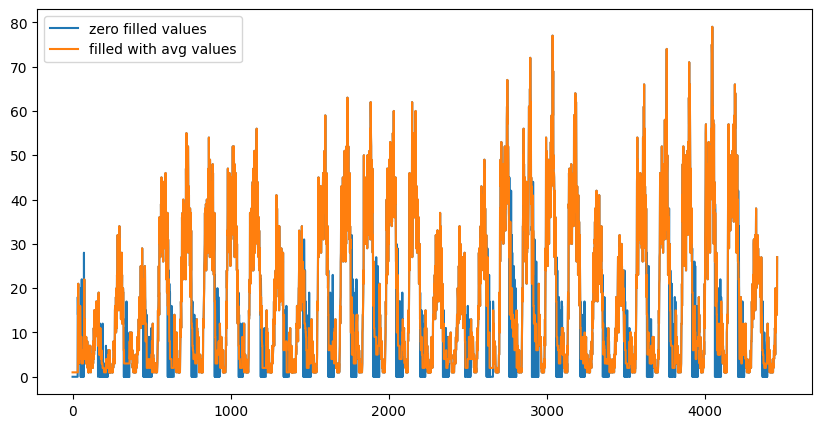

In [ ]:
# sample plot that shows two variations of filling missing values
# we have taken the number of pickups for cluster region 2
plt.figure(figsize=(10,5))
plt.plot(jan_2021_fill[4464:8920], label="zero filled values")
plt.plot(jan_2021_smooth[4464:8920], label="filled with avg values")
plt.legend()
plt.show()

In [ ]:
jan_2021_smooth = smoothing(jan_2021_groupby['trip_distance'].values,jan_2021_unique)
jan_2022_smooth = fill_missing(jan_2022_groupby['trip_distance'].values,jan_2022_unique,1)
feb_2022_smooth = fill_missing(feb_2022_groupby['trip_distance'].values,feb_2022_unique,2)
mar_2022_smooth = fill_missing(mar_2022_groupby['trip_distance'].values,mar_2022_unique,3)

Making list of all the values of pickup data in every bin for a period of 3 months and storing them region-wise 

In [ ]:
regions_cum = []

for i in range(0,48):
    regions_cum.append(jan_2022_smooth[4464*i:4464*(i+1)]+feb_2022_smooth[4032*i:4032*(i+1)]+mar_2022_smooth[4464*i:4464*(i+1)])

print(len(regions_cum))

print(len(regions_cum[0]))



48
12960


Preparing the Dataframe only with x(i) values as jan-2021 data and y(i) values as jan-2022

In [ ]:
ratios_jan = pd.DataFrame()
ratios_jan['Given']=jan_2021_fill
ratios_jan['2022']=jan_2022_smooth
ratios_jan['Ratios']=ratios_jan['2022']*1.0/ratios_jan['Given']*1.0

In [ ]:
ratios_jan = ratios_jan[ratios_jan['Given'] > 0]
ratios_jan = ratios_jan[ratios_jan['2022']>0]

In [ ]:
ratios_jan.head()

,Given,2022,Ratios
33,1,5,5.0
34,2,14,7.0
35,2,10,5.0
36,13,13,1.0
37,6,24,4.0


## Modelling: Baseline Models

Now we get into modelling in order to forecast the pickup densities for the months of Jan, Feb and March of 2022 for which we are using multiple models with two variations 
1. Using Ratios of the 2022 data to the 2021 data i.e $\begin{align} R_{t} = P^{2022}_{t} / P^{2021}_{t} \end{align}$
2. Using Previous known values of the 2022 data itself to predict the future values

### Simple Moving Averages
The First Model used is the Moving Averages Model which uses the previous n values in order to predict the next value <br> 

Using Ratio Values - $\begin{align}R_{t} = ( R_{t-1} + R_{t-2} + R_{t-3} .... R_{t-n} )/n \end{align}$

In [ ]:
def moving_averages_ratios(r, n):
    ratios = r.copy()
    lab = 'SMA'+str(n)
    ratios[lab] = ratios['Ratios'].rolling(n).mean()
    ratios['Pred'] = ratios[lab] * ratios['Given']
    ratios['AbsError'] = abs(ratios['Pred'] - ratios['2022'])
    #print(ratios.loc[ratios['Pred'] == 0])
    ratios['mae'] = ratios['AbsError']/ratios['2022']
    ratios['se'] = ((ratios['Pred'] - ratios['2022'])**2)
    ratios.dropna(inplace=True)
    ratios[['Ratios', lab]].plot(label='Ratios',figsize=(16, 8))
    mape = ratios['mae'].mean()
    mse = ratios['se'].sum()/len(ratios['se'])
    print(ratios.head())
    
    #Plotting the moving averages
    
    return mape, mse

    Given  2022  Ratios  SMA5  Pred  AbsError       mae     se
37      6    24     4.0   4.4  26.4       2.4  0.100000   5.76
38      4    16     4.0   4.2  16.8       0.8  0.050000   0.64
39      1    12    12.0   5.2   5.2       6.8  0.566667  46.24
40      1    12    12.0   6.6   6.6       5.4  0.450000  29.16
41      1    10    10.0   8.4   8.4       1.6  0.160000   2.56
Mean Absolute Percentage Error: 0.6524548235152274
Mean Square Error: 150.95339992256402
Root Mean Square Error: 12.28630945087108
    Given  2022     Ratios     SMA10       Pred   AbsError       mae  \
42      1    12  12.000000  7.200000   7.200000   4.800000  0.400000   
43      3    11   3.666667  7.066667  21.200000  10.200000  0.927273   
44      2    12   6.000000  6.966667  13.933333   1.933333  0.161111   
45      1    12  12.000000  7.666667   7.666667   4.333333  0.361111   
46      4    12   3.000000  7.866667  31.466667  19.466667  1.622222   

            se  
42   23.040000  
43  104.040000  
44    3

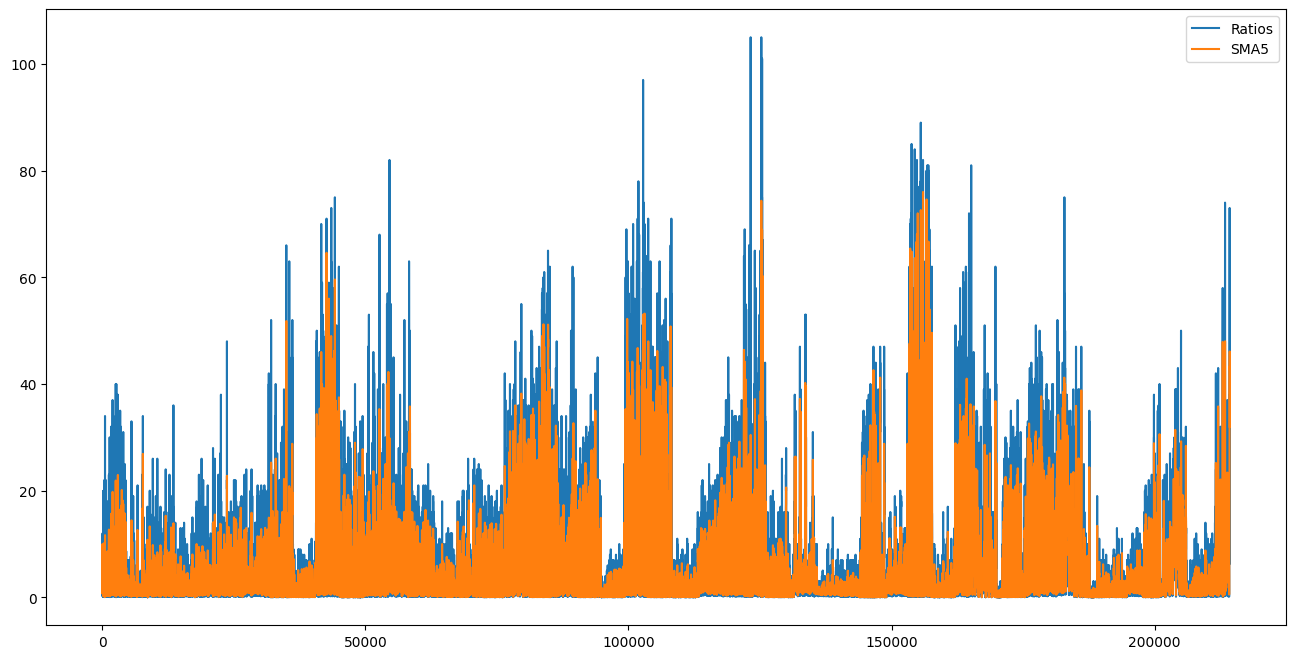

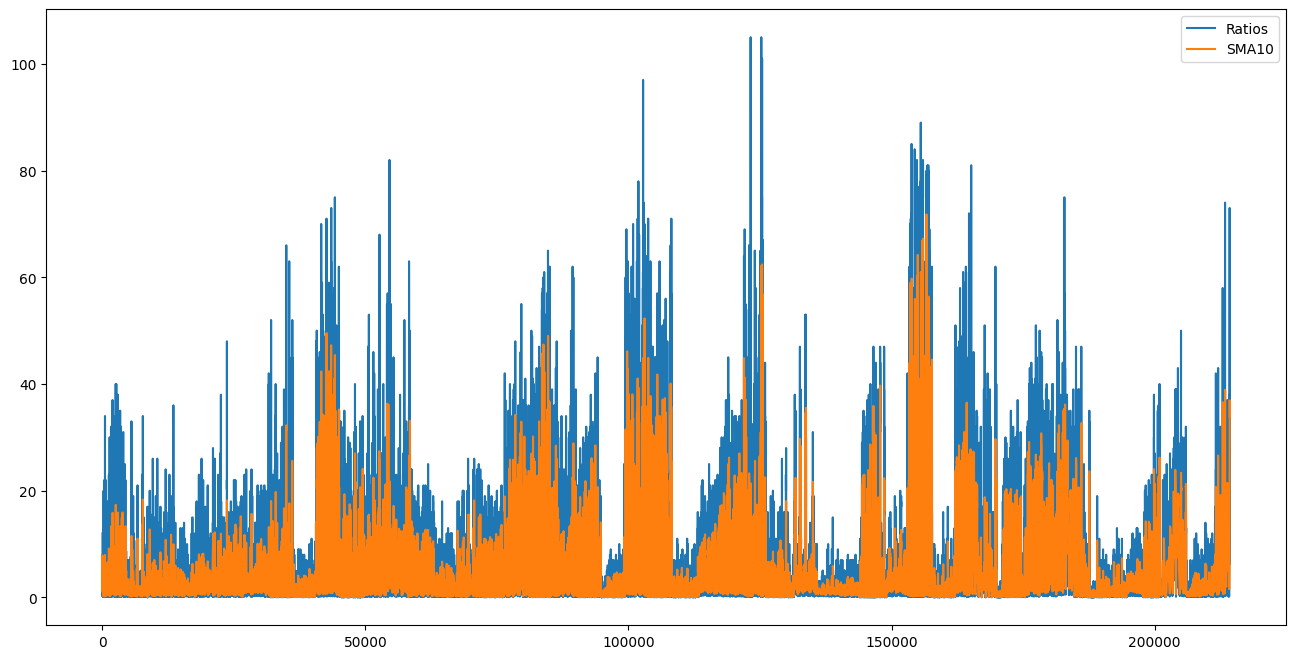

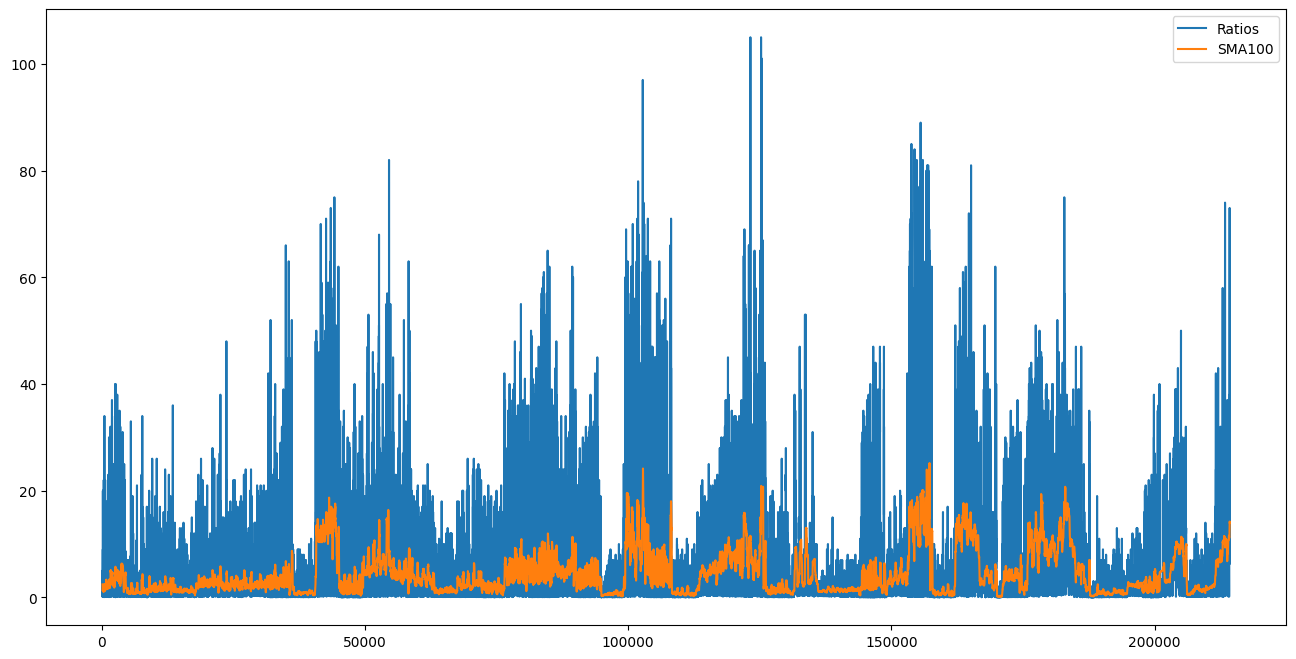

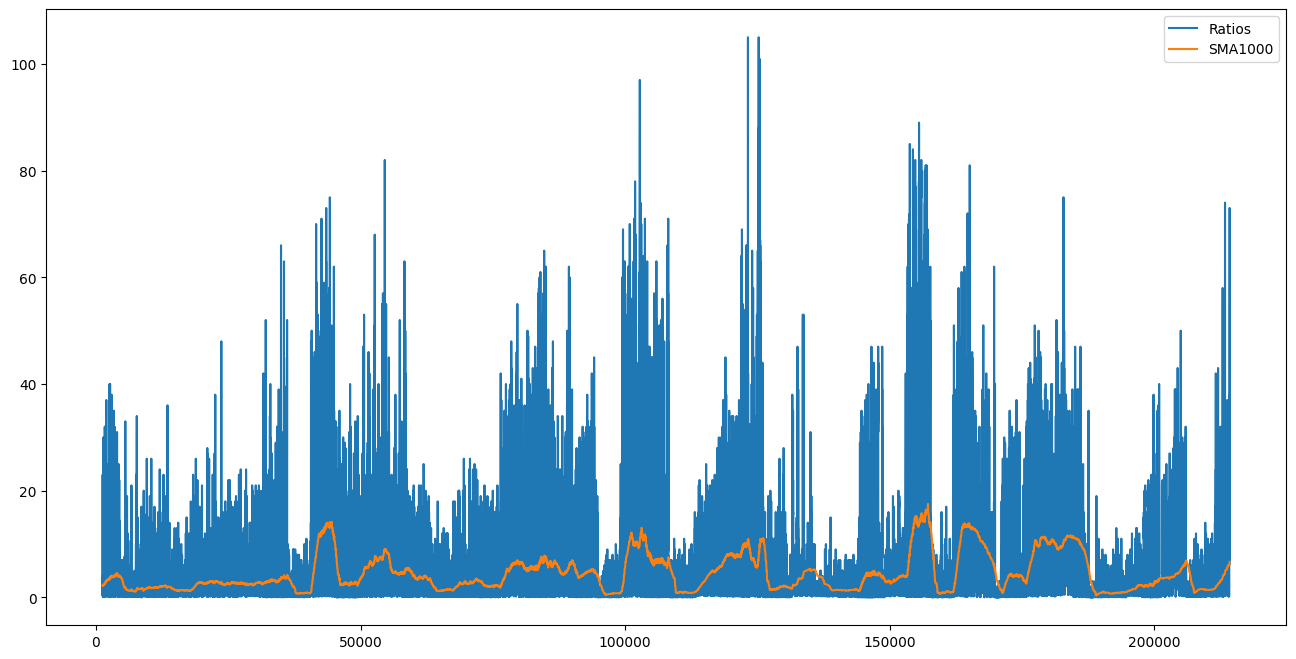

In [ ]:
mape, mse = moving_averages_ratios(ratios_jan,5)
print("Mean Absolute Percentage Error: "+ str(mape))
print("Mean Square Error: "+ str(mse))
print("Root Mean Square Error: "+str((mse)**(0.5)))

mape, mse = moving_averages_ratios(ratios_jan,10)
print("Mean Absolute Percentage Error: "+ str(mape))
print("Mean Square Error: "+ str(mse))
print("Root Mean Square Error: "+str((mse)**(0.5)))

mape, mse = moving_averages_ratios(ratios_jan,100)
print("Mean Absolute Percentage Error: "+ str(mape))
print("Mean Square Error: "+ str(mse))
print("Root Mean Square Error: "+str((mse)**(0.5)))

mape, mse = moving_averages_ratios(ratios_jan,1000)
print("Mean Absolute Percentage Error: "+ str(mape))
print("Mean Square Error: "+ str(mse))
print("Root Mean Square Error: "+str((mse)**(0.5)))

In [ ]:
#Choosing 5 as the most suitable value

    Given  2022  Ratios  SMA5  Pred  AbsError       mae     se
37      6    24     4.0   4.4  26.4       2.4  0.100000   5.76
38      4    16     4.0   4.2  16.8       0.8  0.050000   0.64
39      1    12    12.0   5.2   5.2       6.8  0.566667  46.24
40      1    12    12.0   6.6   6.6       5.4  0.450000  29.16
41      1    10    10.0   8.4   8.4       1.6  0.160000   2.56
Mean Absolute Percentage Error: 0.6524548235152274
Mean Square Error: 150.95339992256402
Root Mean Square Error: 12.28630945087108


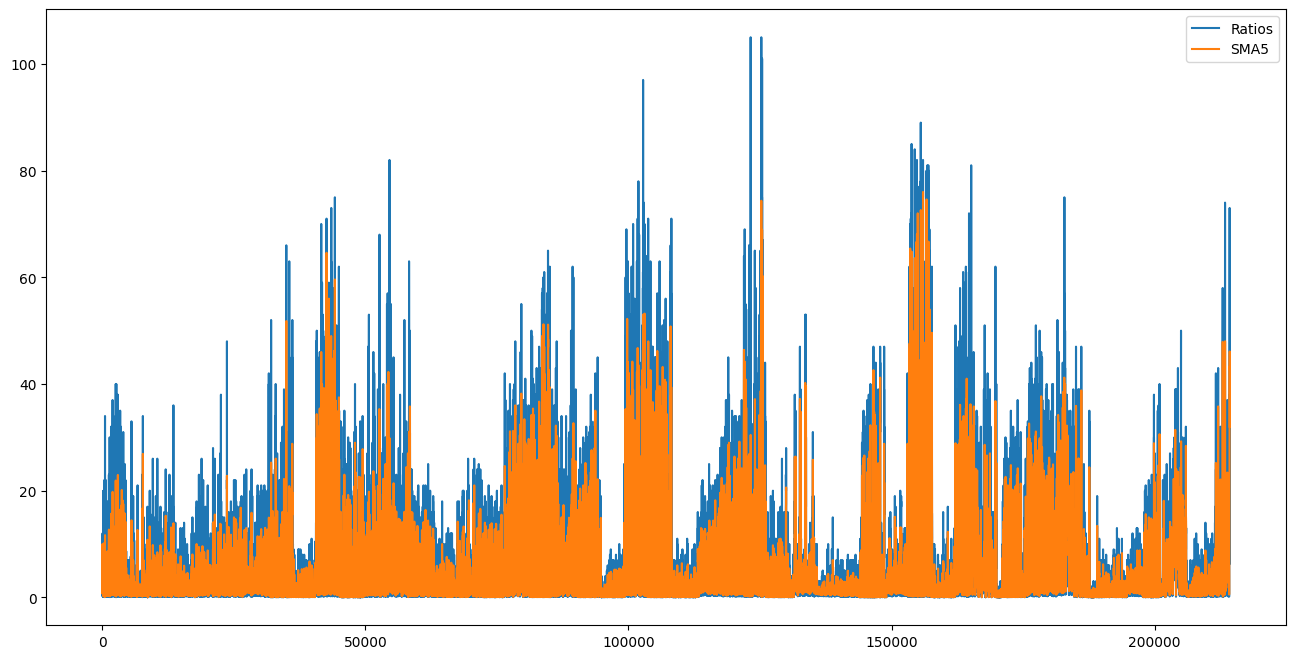

In [ ]:
mape, mse = moving_averages_ratios(ratios_jan,5)
print("Mean Absolute Percentage Error: "+ str(mape))
print("Mean Square Error: "+ str(mse))
print("Root Mean Square Error: "+str((mse)**(0.5)))

In [ ]:
#We can apply gradient descent to tune the hyper parameter(n), should we or too complex?

Next we use the Moving averages of the 2022  values itself to predict the future value using $\begin{align}P_{t} = ( P_{t-1} + P_{t-2} + P_{t-3} .... P_{t-n} )/n \end{align}$

In [ ]:
def moving_averages_prev(r, n):
    ratios = r.copy()
    ratios['Pred'] = ratios['2022'].rolling(n).mean()
    ratios['AbsError'] = abs(ratios['Pred'] - ratios['2022'])
    #print(ratios.loc[ratios['Pred'] == 0])
    ratios['mae'] = ratios['AbsError']/ratios['2022']
    ratios['se'] = ((ratios['Pred'] - ratios['2022'])**2)
    ratios.dropna(inplace=True)
    ratios[['2022', 'Pred']].plot(label='Predicted',figsize=(16, 8))
    mape = ratios['mae'].mean()
    mse = ratios['se'].sum()/len(ratios['se'])
    print(ratios.head())
    #Plotting the moving averages
    
    return mape, mse

    Given  2022  Ratios  Pred  AbsError       mae     se
34      2    14     7.0   9.5       4.5  0.321429  20.25
35      2    10     5.0  12.0       2.0  0.200000   4.00
36     13    13     1.0  11.5       1.5  0.115385   2.25
37      6    24     4.0  18.5       5.5  0.229167  30.25
38      4    16     4.0  20.0       4.0  0.250000  16.00
(0.23232080581420547, 7.962542285710146)
    Given  2022  Ratios  Pred  AbsError       mae      se
37      6    24     4.0  13.2      10.8  0.450000  116.64
38      4    16     4.0  15.4       0.6  0.037500    0.36
39      1    12    12.0  15.0       3.0  0.250000    9.00
40      1    12    12.0  15.4       3.4  0.283333   11.56
41      1    10    10.0  14.8       4.8  0.480000   23.04
(0.36093121463282934, 17.819240253248918)
    Given  2022     Ratios  Pred  AbsError       mae    se
42      1    12  12.000000  12.8       0.8  0.066667  0.64
43      3    11   3.666667  13.4       2.4  0.218182  5.76
44      2    12   6.000000  13.2       1.2  0.1000

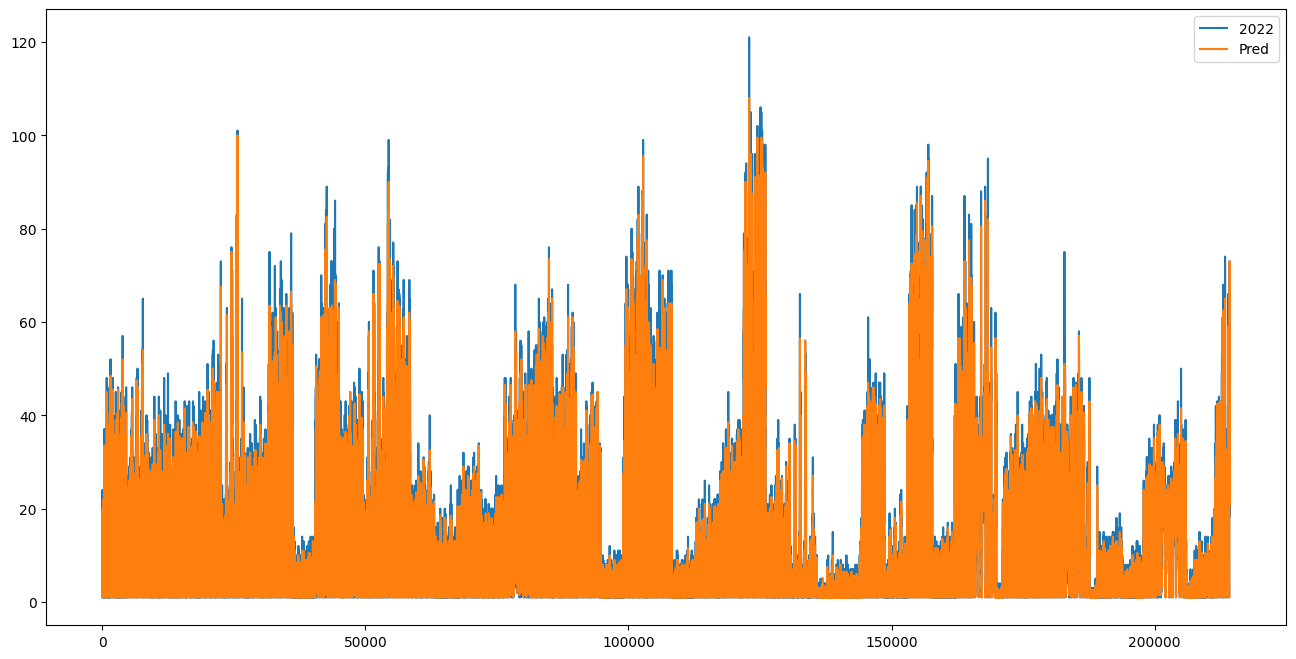

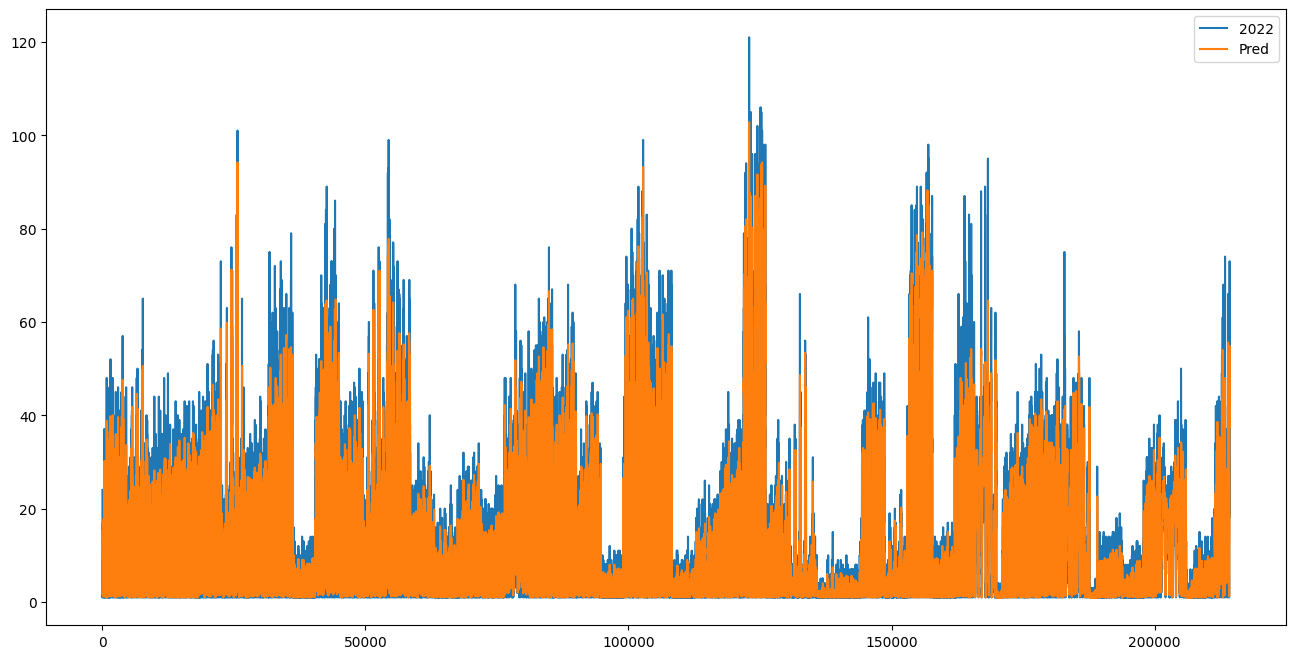

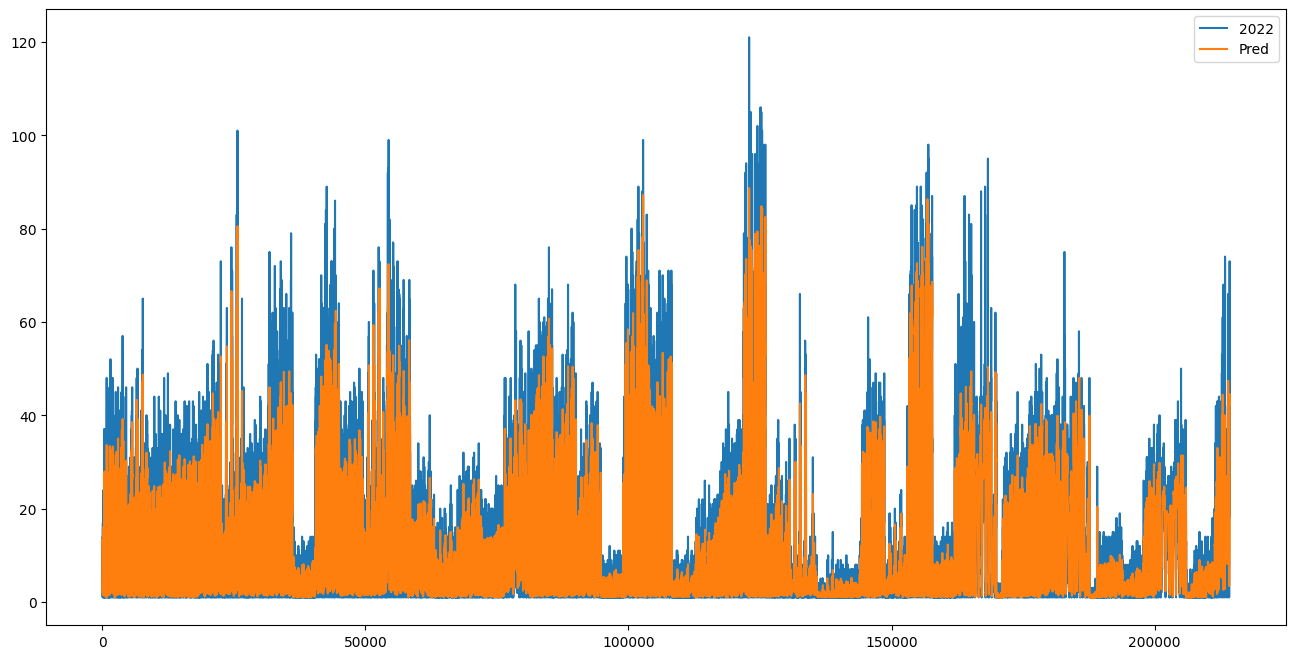

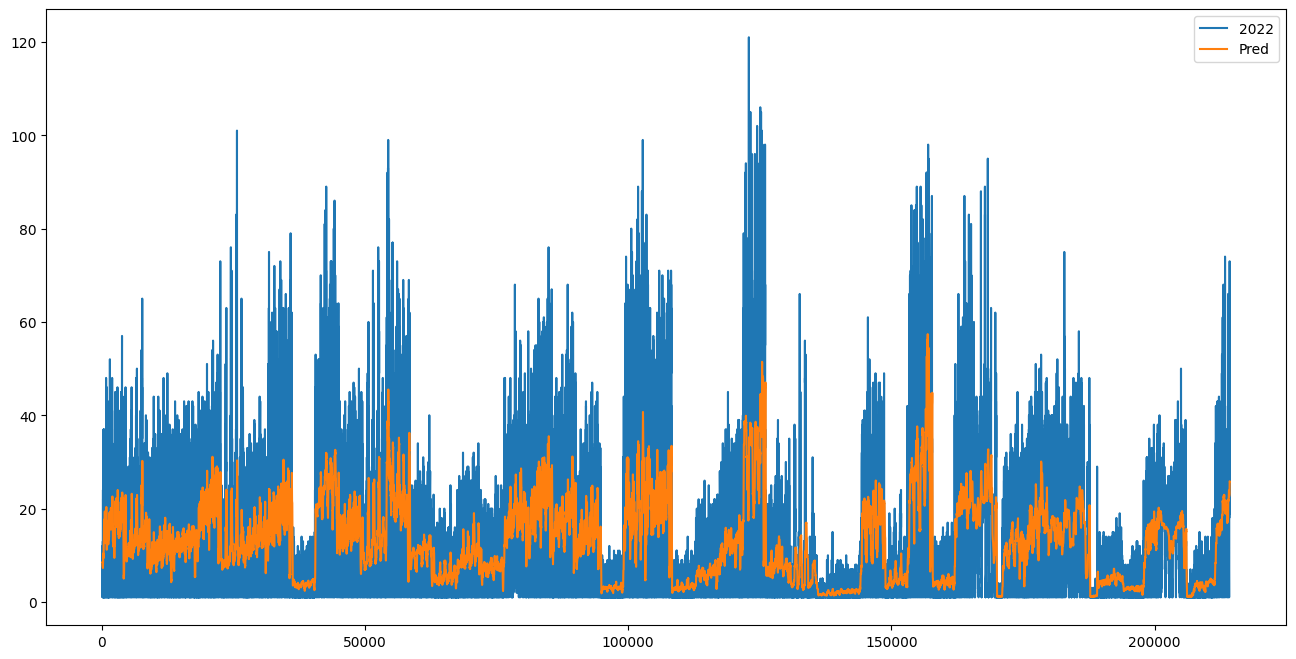

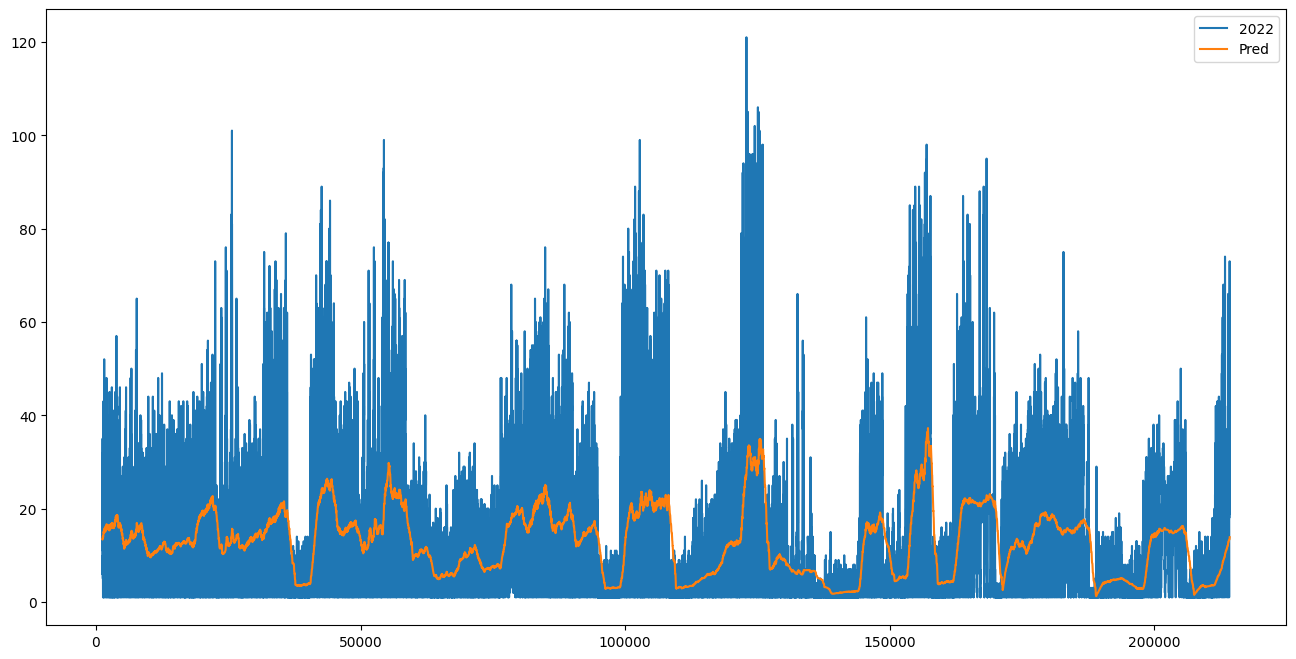

In [ ]:
print(moving_averages_prev(ratios_jan, 2))
print(moving_averages_prev(ratios_jan, 5))
print(moving_averages_prev(ratios_jan, 10))
print(moving_averages_prev(ratios_jan, 100))
print(moving_averages_prev(ratios_jan, 1000))

In [ ]:
#Moving averages for 2022 values itself is much more accurate than with the ratios
#Where window size is 2

    Given  2022  Ratios  Pred  AbsError       mae     se
34      2    14     7.0   9.5       4.5  0.321429  20.25
35      2    10     5.0  12.0       2.0  0.200000   4.00
36     13    13     1.0  11.5       1.5  0.115385   2.25
37      6    24     4.0  18.5       5.5  0.229167  30.25
38      4    16     4.0  20.0       4.0  0.250000  16.00
(0.23232080581420547, 7.962542285710146)


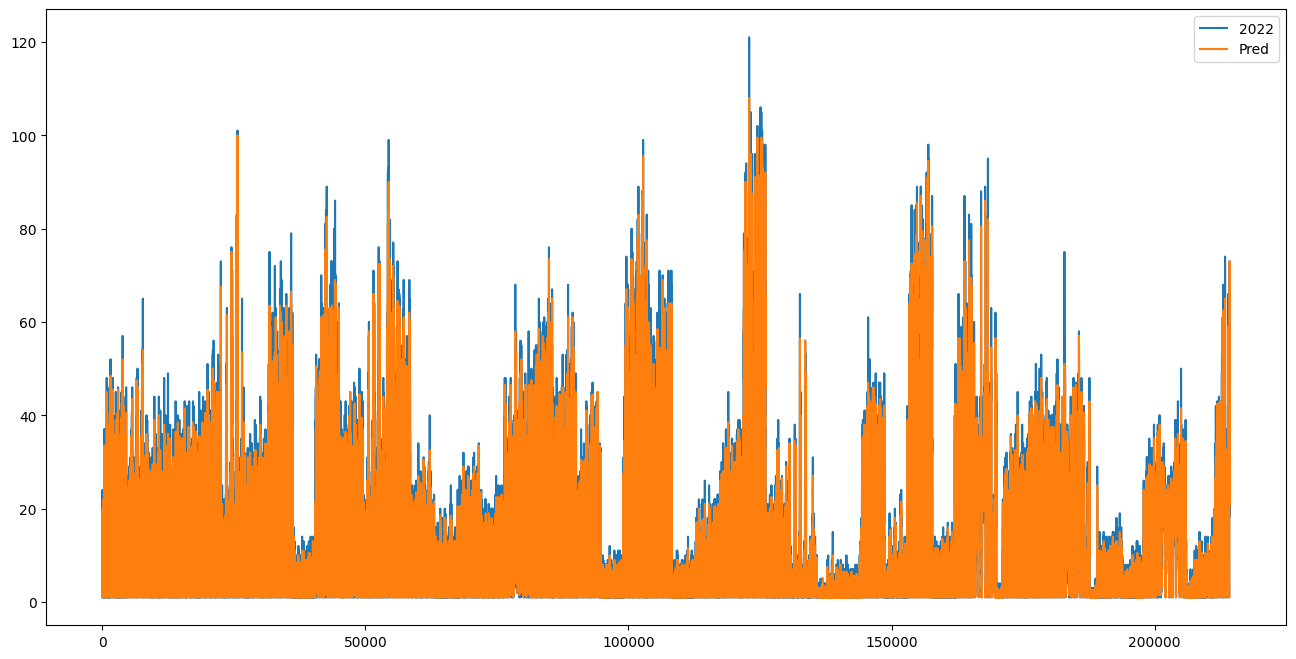

In [ ]:
print(moving_averages_prev(ratios_jan, 2))

## Exponential Moving Averages


Through weighted averaged we have satisfied the analogy of giving higher weights to the latest value and decreasing weights to the subsequent ones but we still do not know which is the correct weighting scheme as there are infinetly many possibilities in which we can assign weights in a non-increasing order and tune the the hyperparameter window-size. To simplify this process we use Exponential Moving Averages which is a more logical way towards assigning weights and at the same time also using an optimal window-size.

In exponential moving averages we use a single hyperparameter alpha $\begin{align}(\alpha)\end{align}$ which is a value between 0 & 1 and based on the value of the hyperparameter alpha the weights and the window sizes are configured.<br>
For eg. If $\begin{align}\alpha=0.9\end{align}$ then the number of days on which the value of the current iteration is based is~$\begin{align}1/(1-\alpha)=10\end{align}$ i.e. we consider values 10 days prior before we predict the value for the current iteration. Also the weights are assigned using $\begin{align}2/(N+1)=0.18\end{align}$ ,where N = number of prior values being considered, hence from this it is implied that the first or latest value is assigned a weight of 0.18 which keeps exponentially decreasing for the subsequent values.

$\begin{align}R^{'}_{t} = \alpha*R_{t-1} + (1-\alpha)*R^{'}_{t-1}  \end{align}$

In [ ]:
def exponential_moving_averages_ratios(r, n):
    ratios = r.copy()
    lab = 'EWMA' + str(n)
    ratios[lab] = ratios['Ratios'].ewm(span=n).mean()
    ratios.dropna(inplace=True)
    ratios['Pred'] = ratios['2022'] * ratios[lab]
    ratios[['Ratios', lab]].plot(label='Ratios',figsize=(16, 8))
    ratios['AbsError'] = abs(ratios['Pred'] - ratios['2022'])
    #print(ratios.loc[ratios['Pred'] == 0])
    ratios['mae'] = ratios['AbsError']/ratios['2022']
    ratios['se'] = ((ratios['Pred'] - ratios['2022'])**2)
    ratios.dropna(inplace=True)
    ratios[['Ratios', lab]].plot(label='Ratios',figsize=(16, 8))
    mape = ratios['mae'].mean()
    mse = ratios['se'].sum()/len(ratios['se'])
    return mape, mse

(3.6400241756292124, 92939.59454311727)
(3.596975302593791, 80275.37956172891)
(3.5248141372130606, 63557.85615705158)
(3.374990224850982, 27388.26516251843)


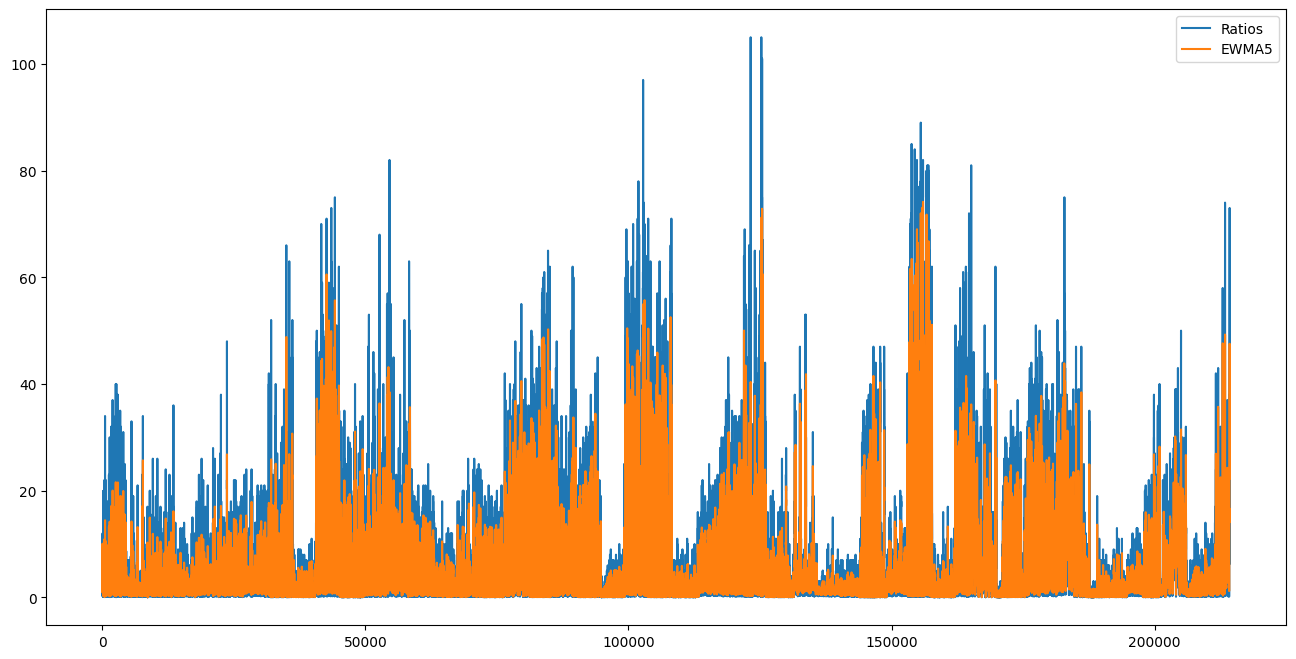

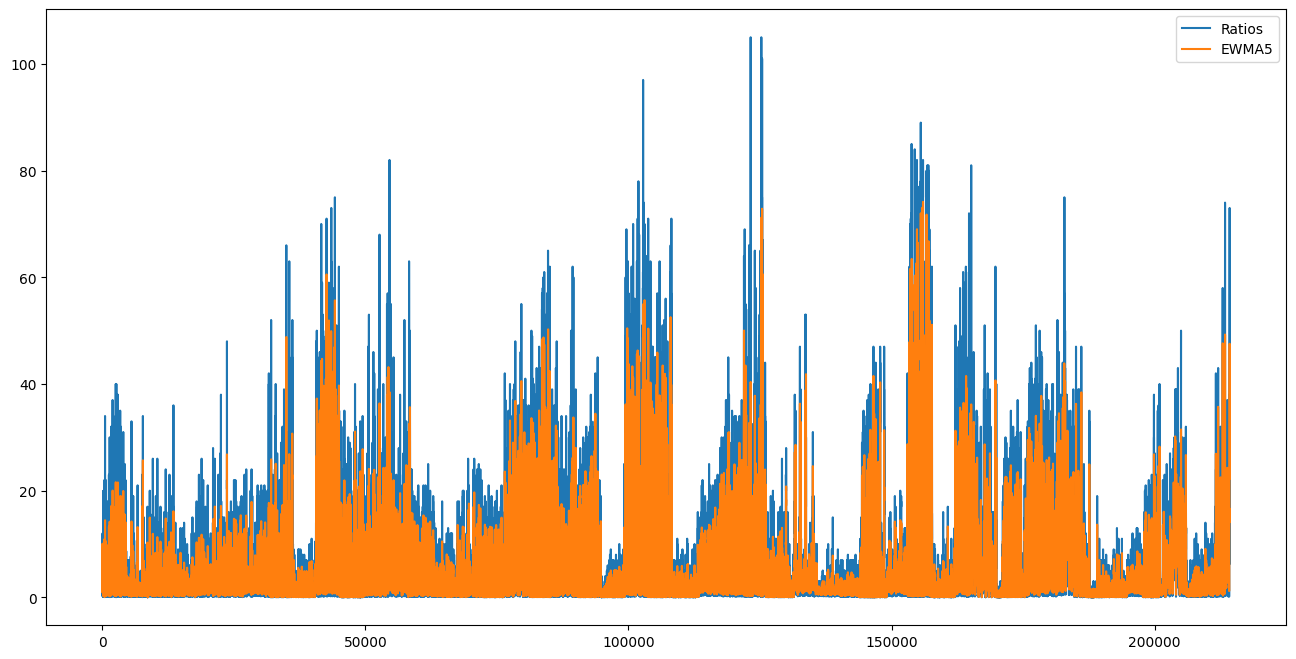

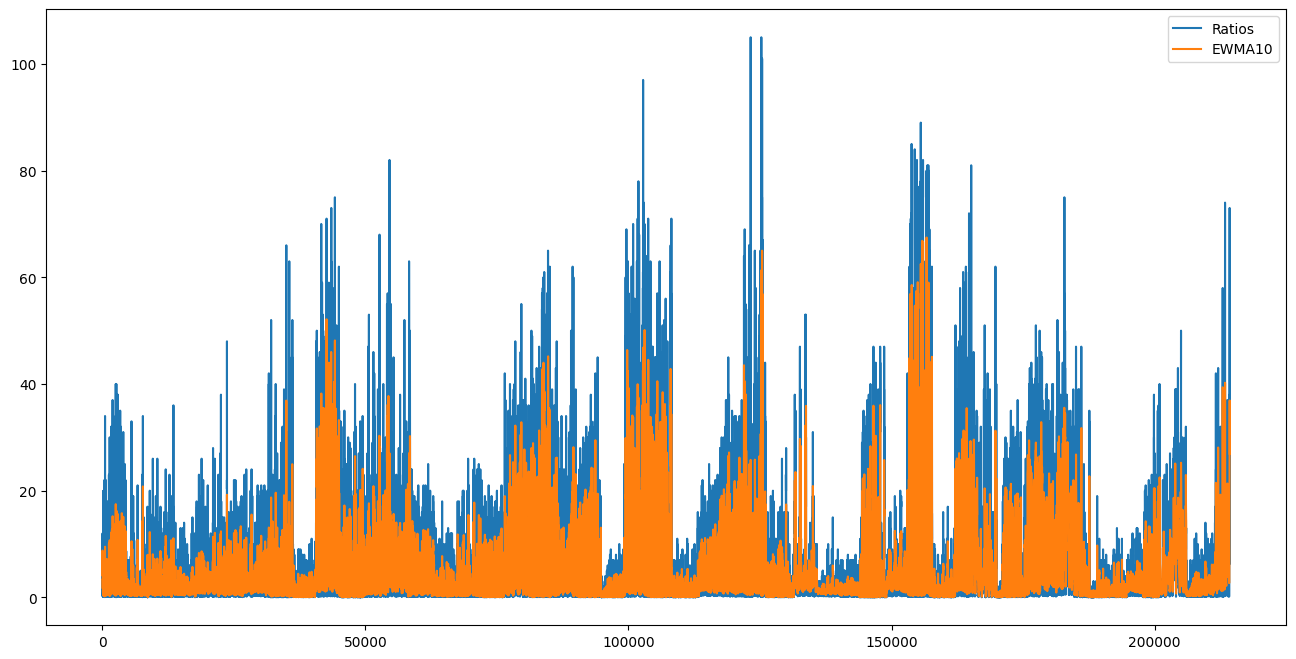

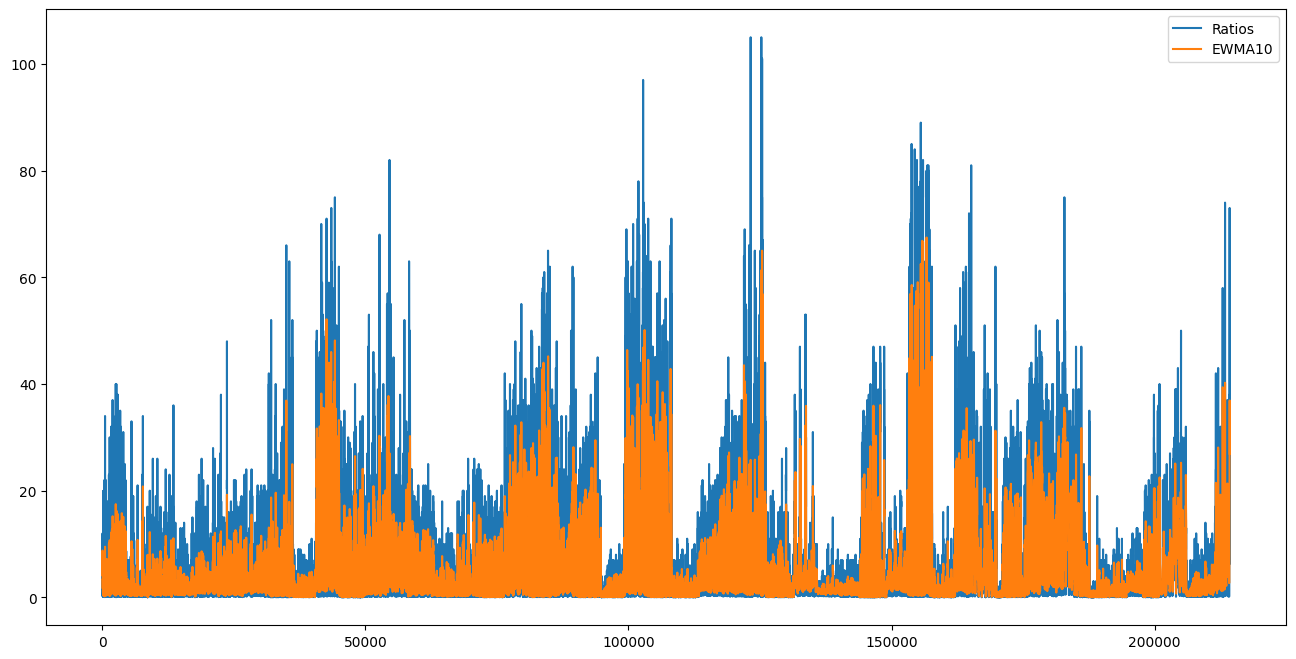

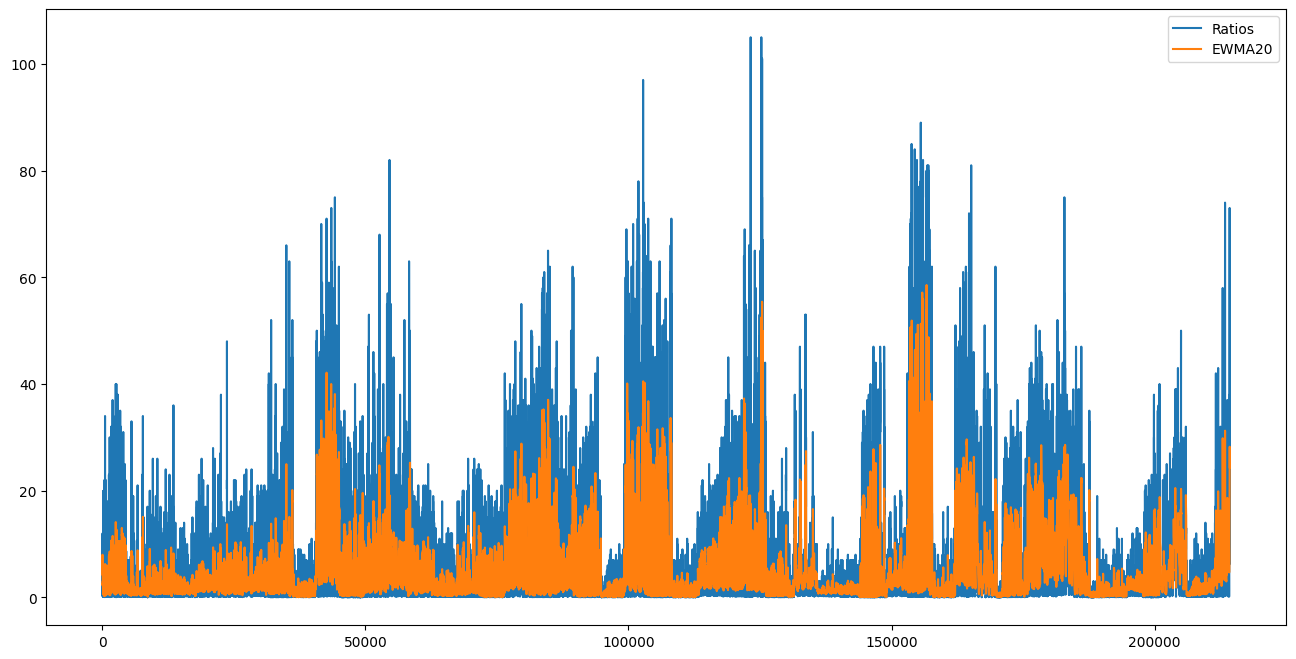

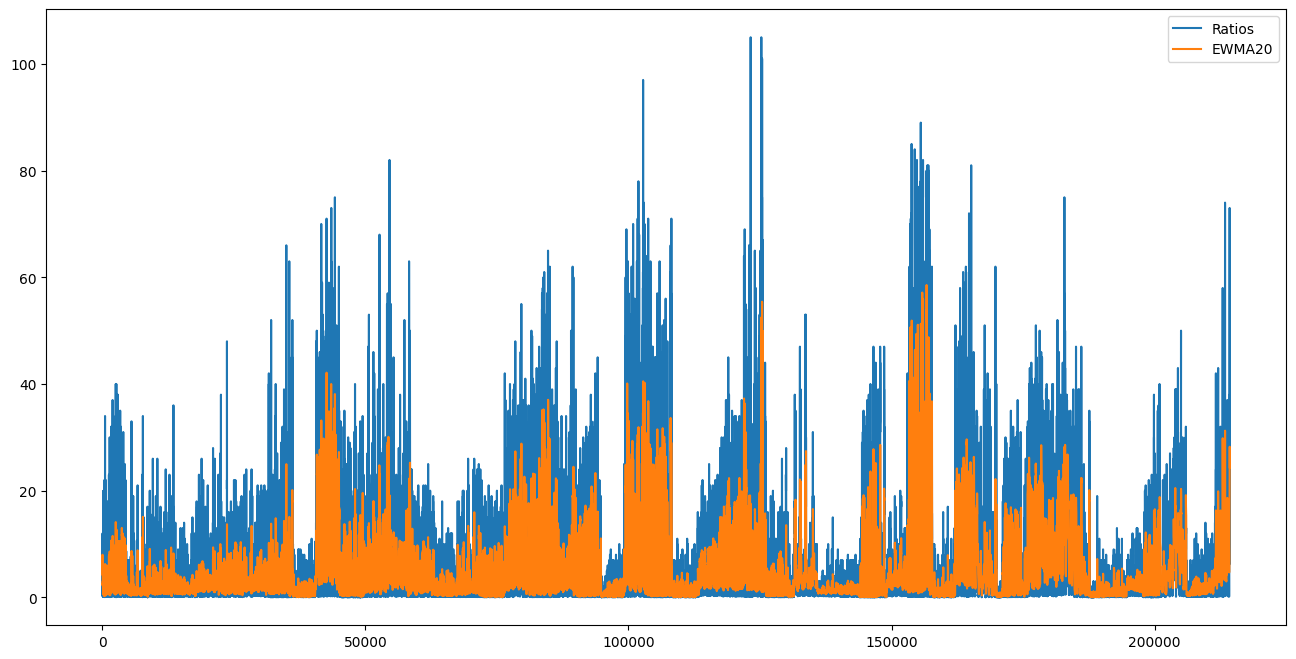

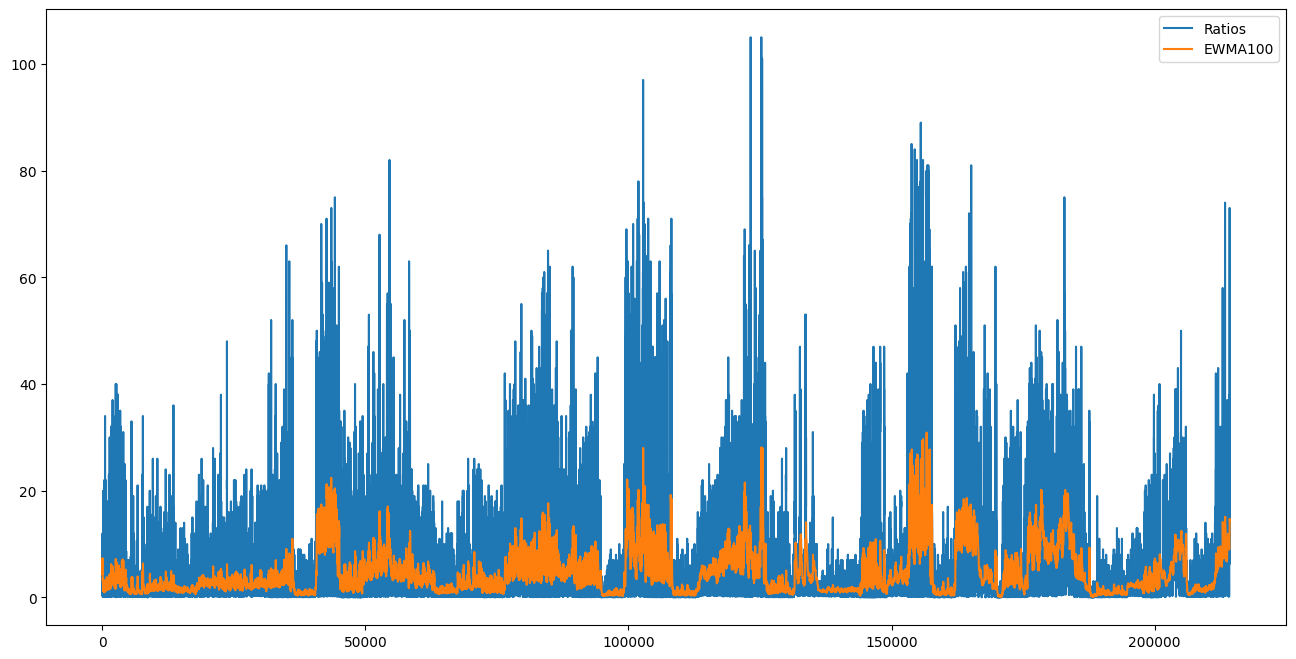

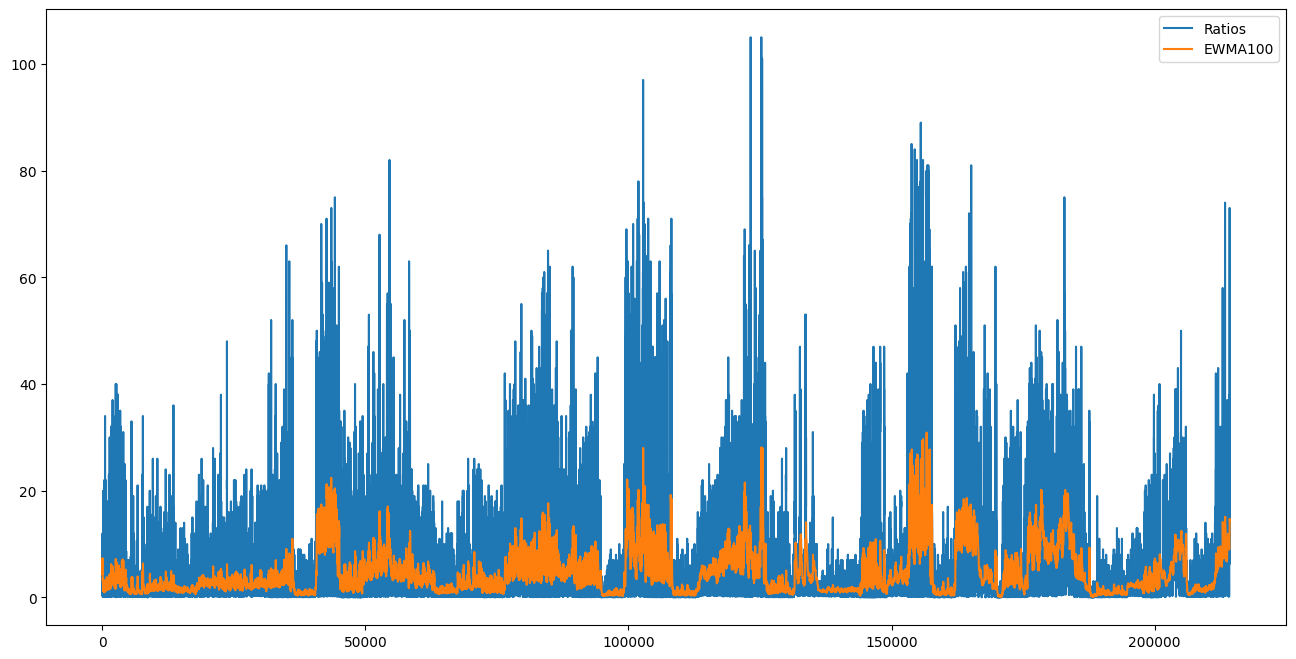

In [ ]:
print(exponential_moving_averages_ratios(ratios_jan, 5))
print(exponential_moving_averages_ratios(ratios_jan, 10))
print(exponential_moving_averages_ratios(ratios_jan, 20))
print(exponential_moving_averages_ratios(ratios_jan, 100))

In [ ]:
def exponential_moving_averages_prev(r, n):
    ratios = r.copy()
    ratios.dropna(inplace=True)
    ratios['Pred'] = ratios['2022'].ewm(span=n).mean()
    ratios[['2022', 'Pred']].plot(label='Predicted Values',figsize=(16, 8))
    ratios['AbsError'] = abs(ratios['Pred'] - ratios['2022'])
    #print(ratios.loc[ratios['Pred'] == 0])
    ratios['mae'] = ratios['AbsError']/ratios['2022']
    ratios['se'] = ((ratios['Pred'] - ratios['2022'])**2)
    ratios.dropna(inplace=True)
    ratios[['2022', 'Pred']].plot(label='Predicted',figsize=(16, 8))
    mape = ratios['mae'].mean()
    mse = ratios['se'].sum()/len(ratios['se'])
    return mape, mse

(1.6282906200827616, 96.31265771147422)
(1.321557928763629, 76.18281675628994)
(1.7887482383125055, 107.60674462958595)
(0.4729472481589726, 22.559638993135327)
(0.310086777363919, 11.887259365179505)


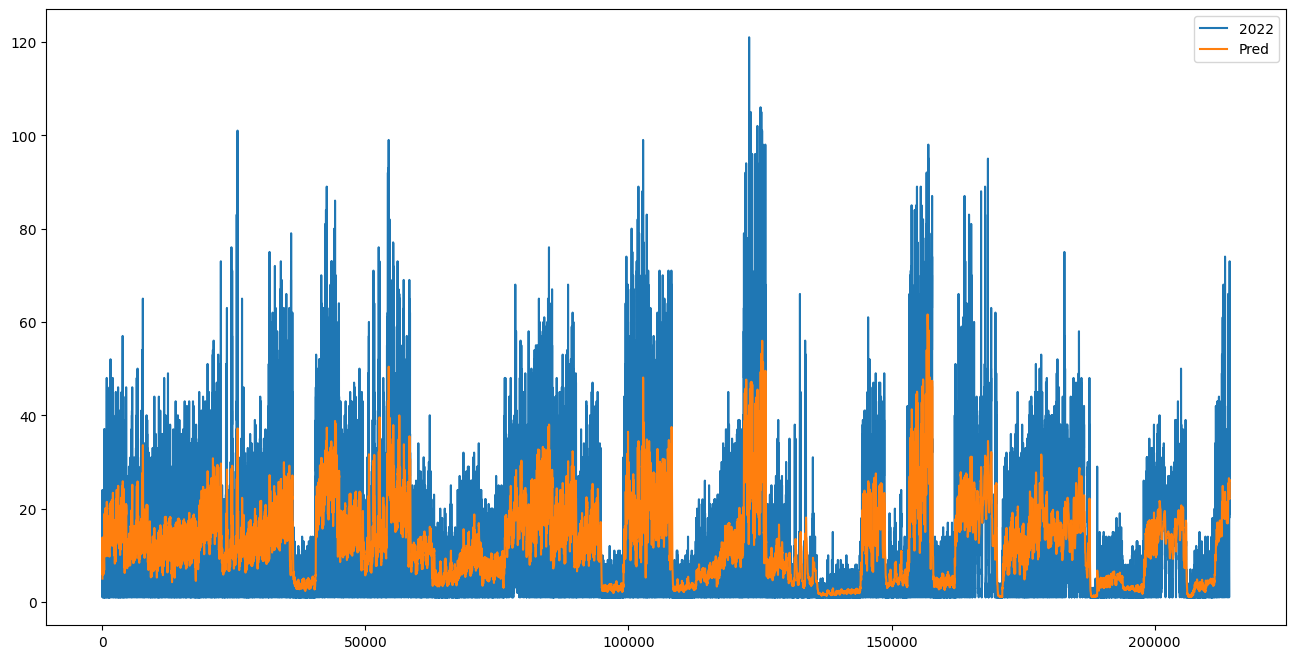

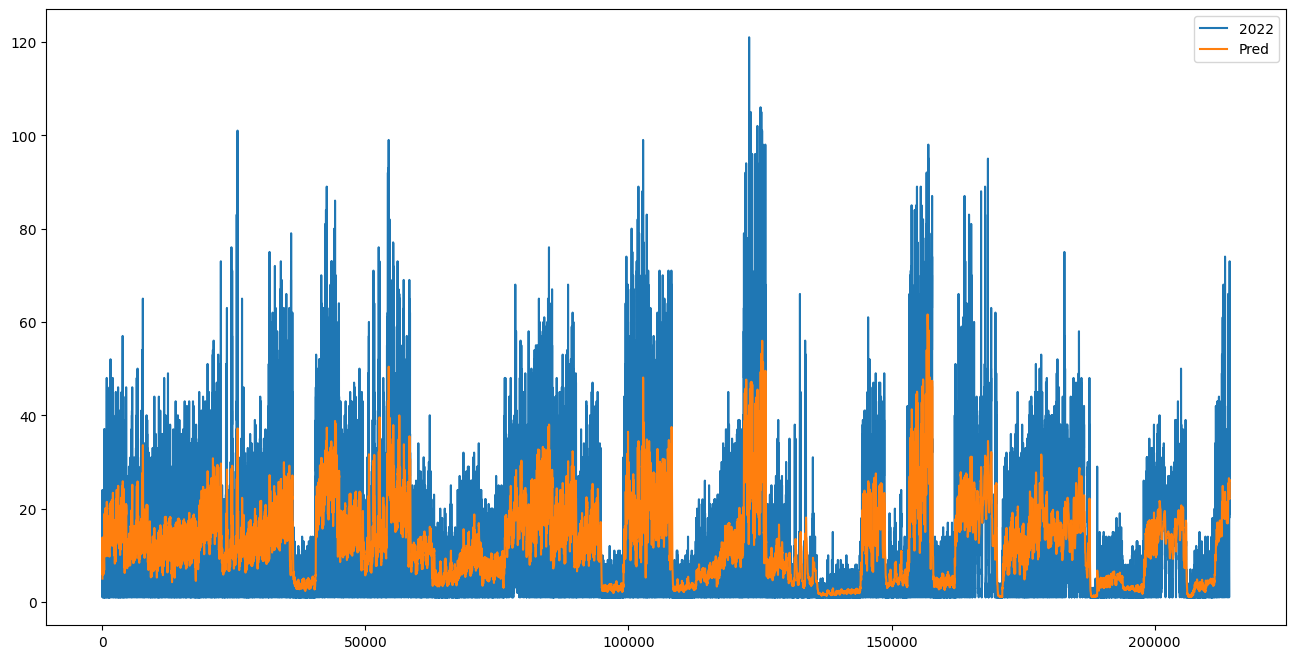

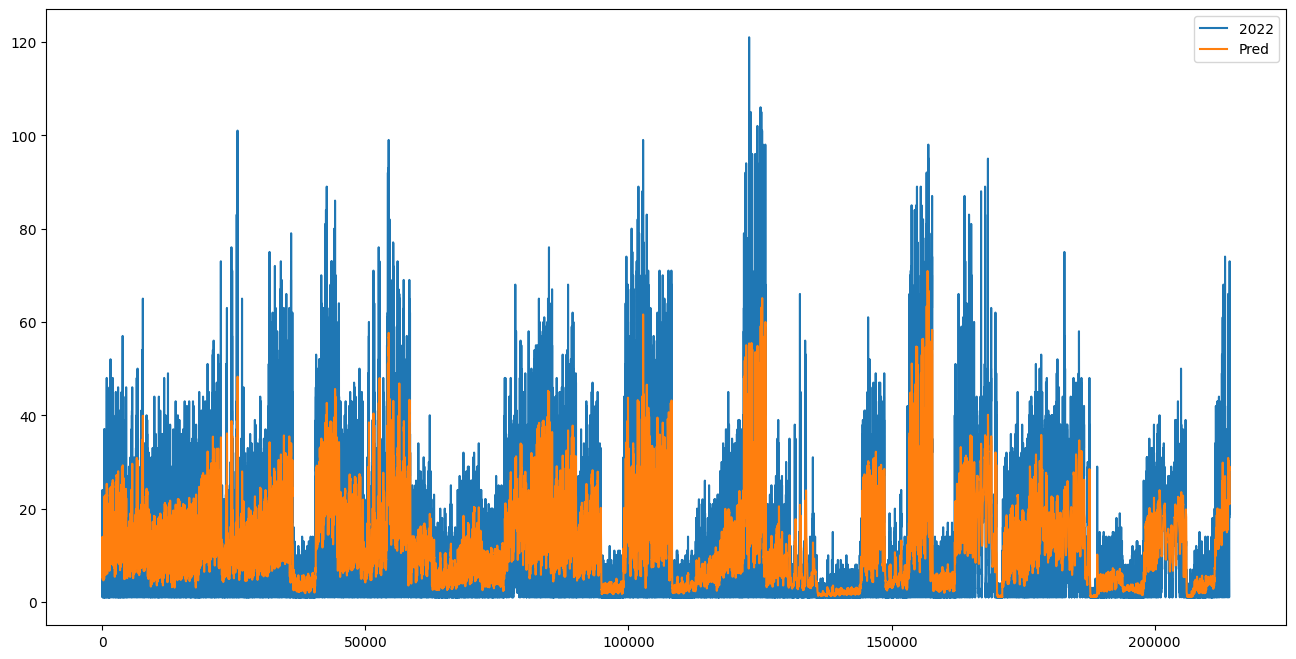

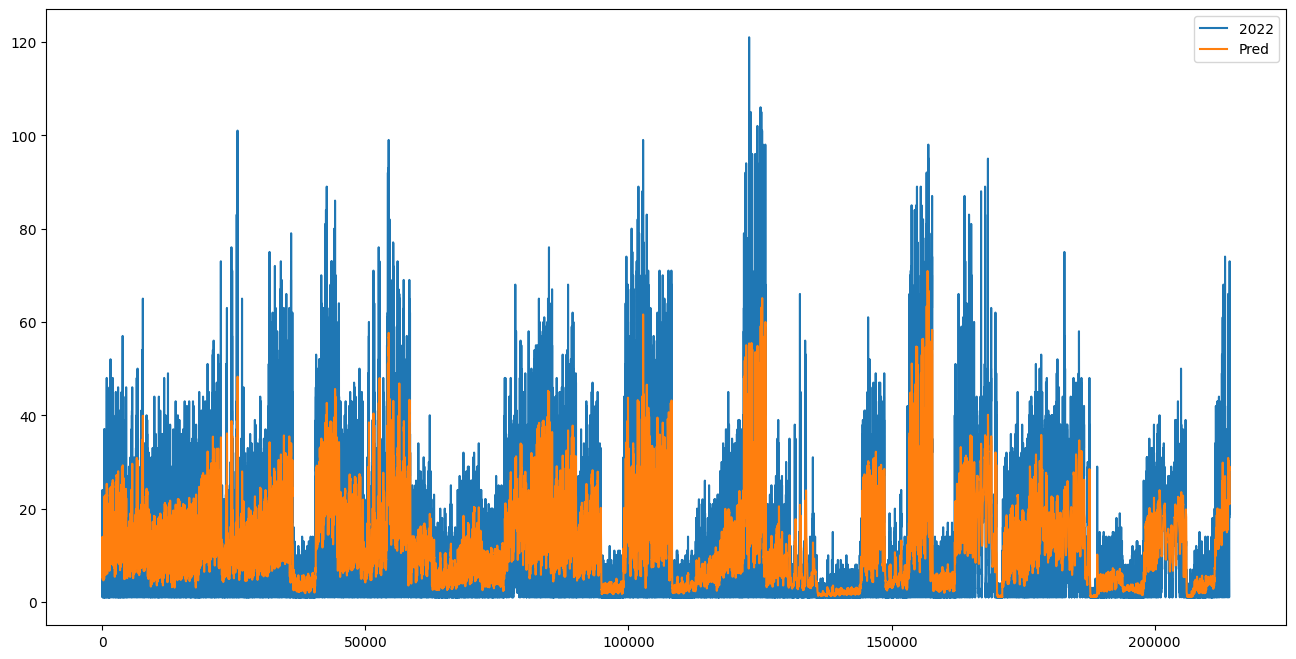

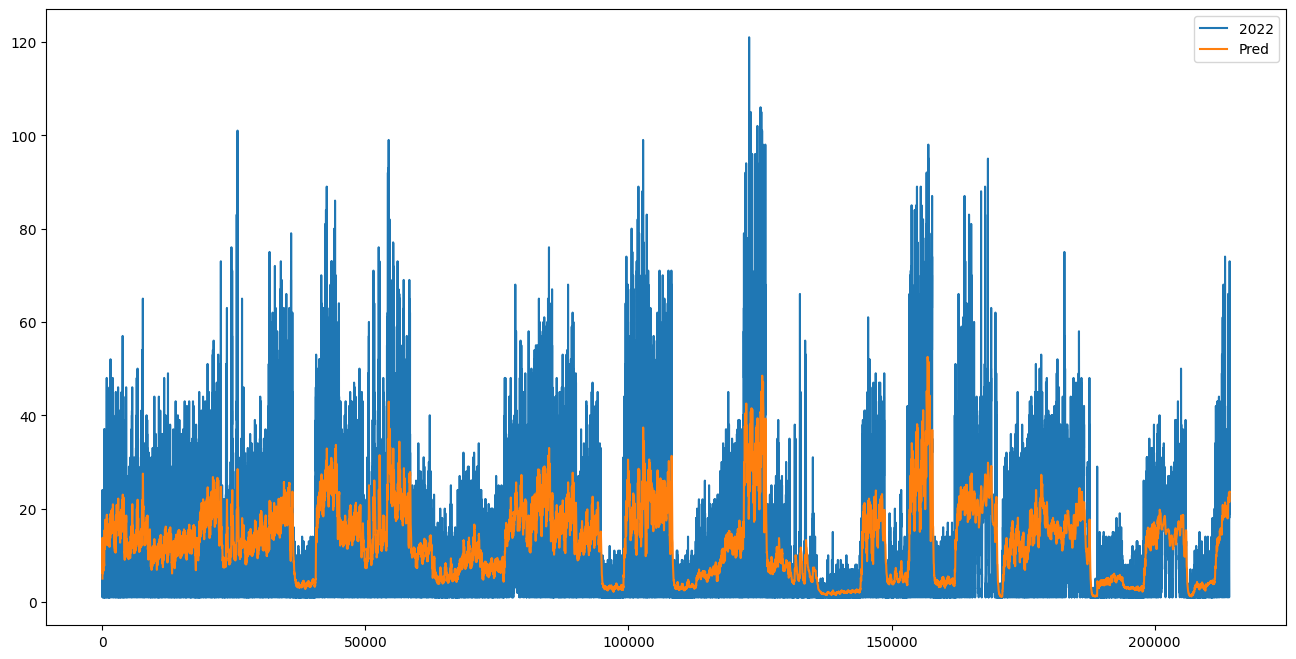

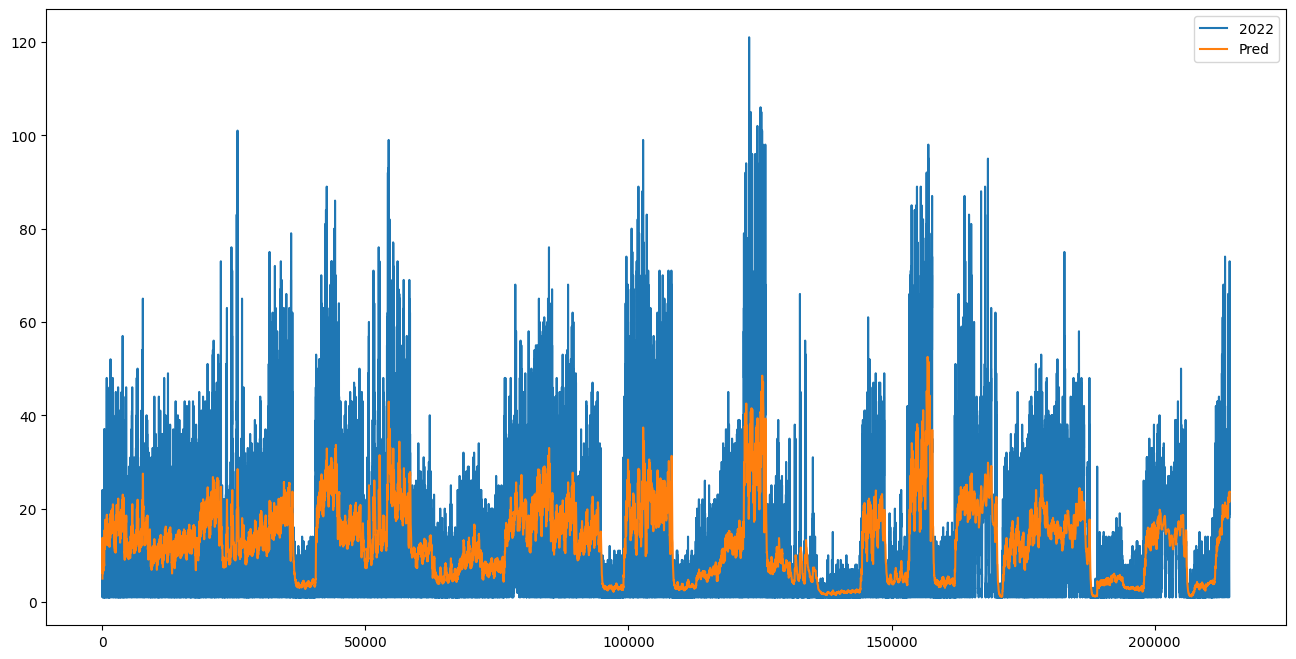

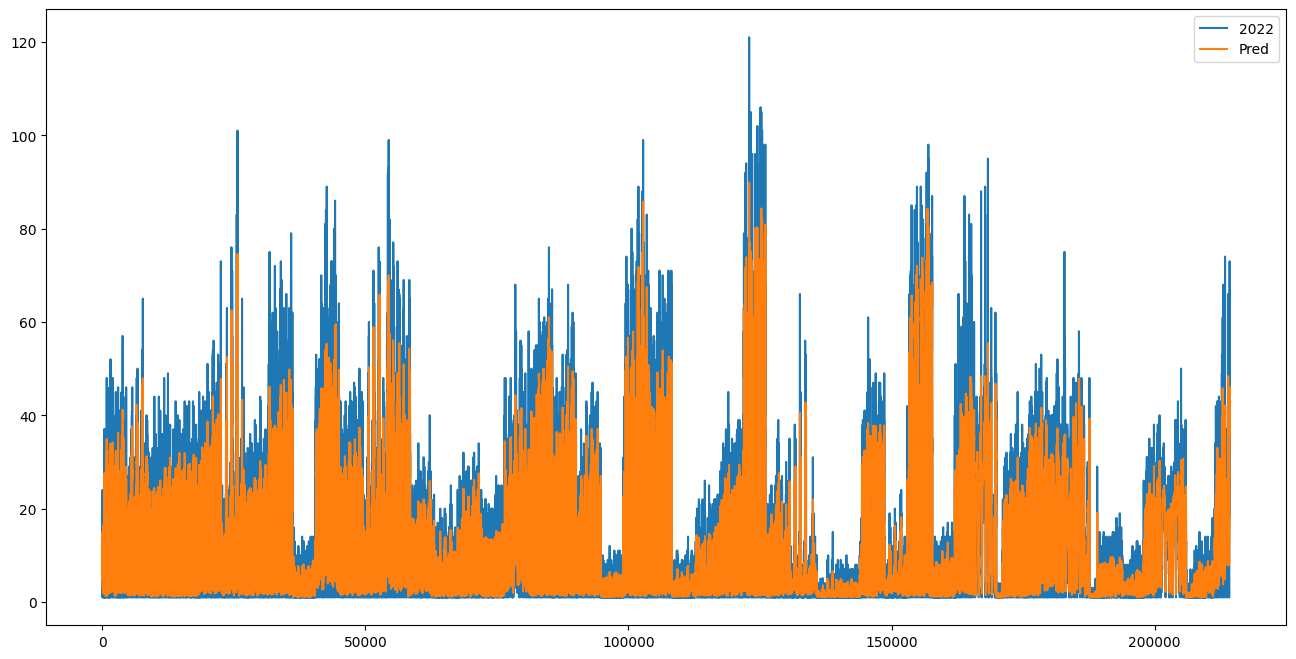

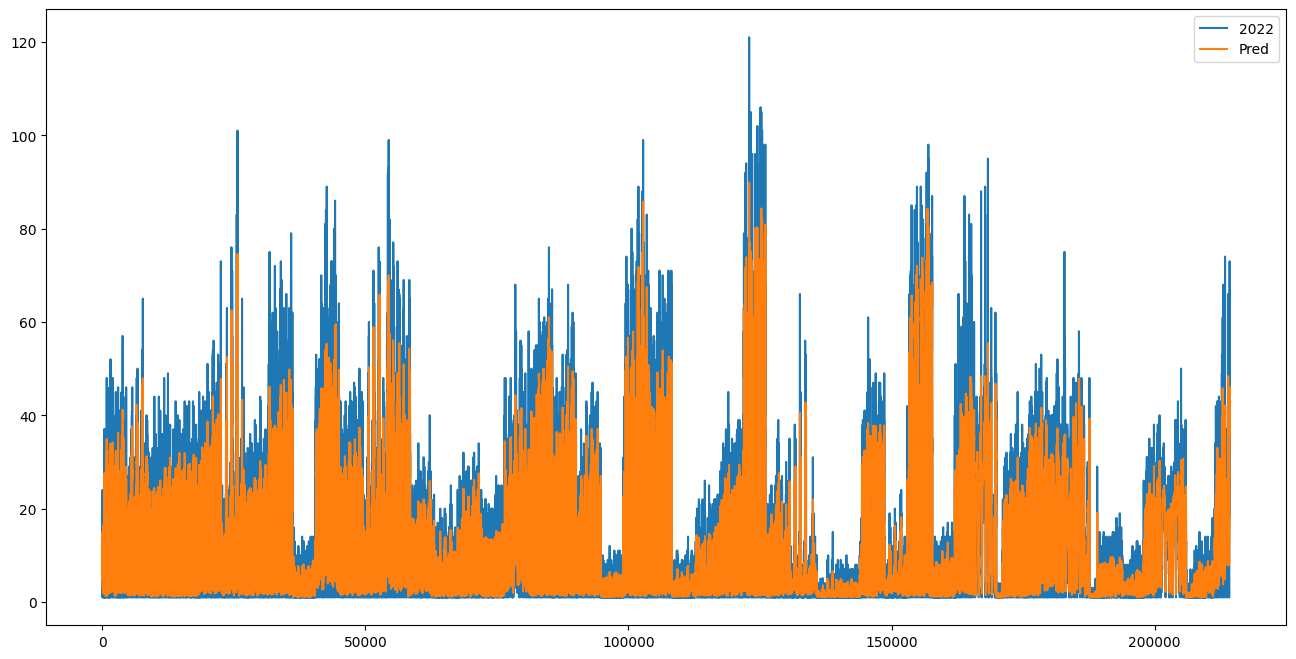

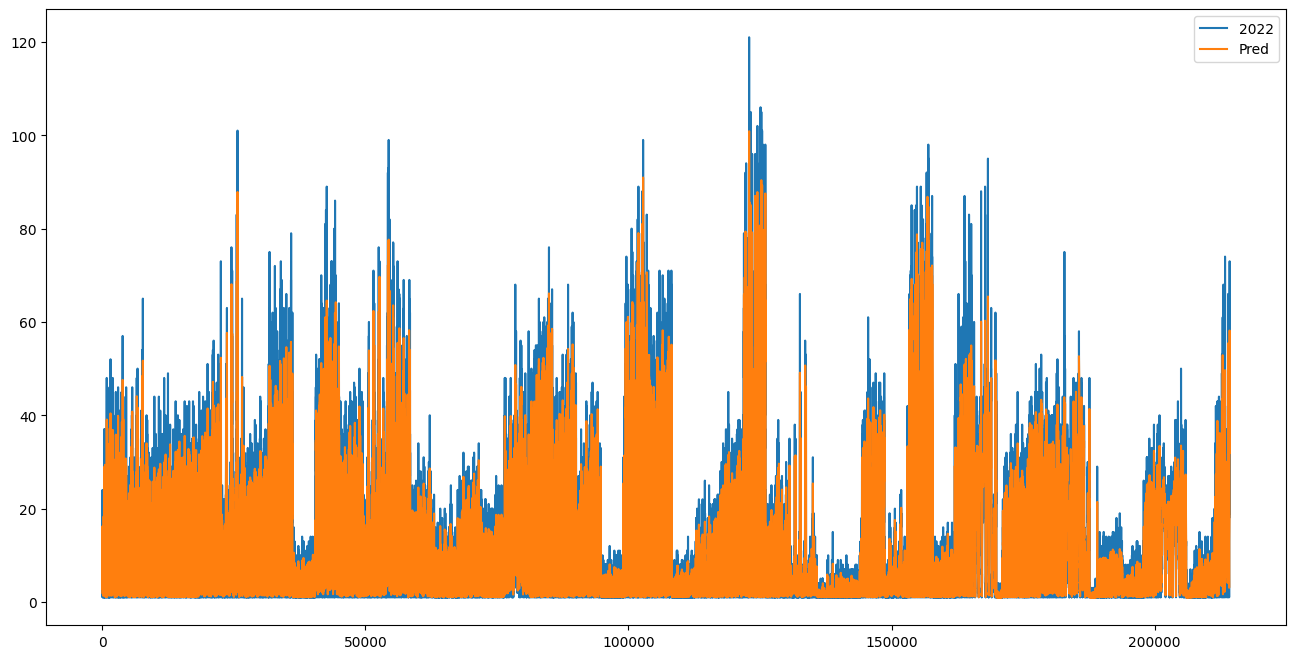

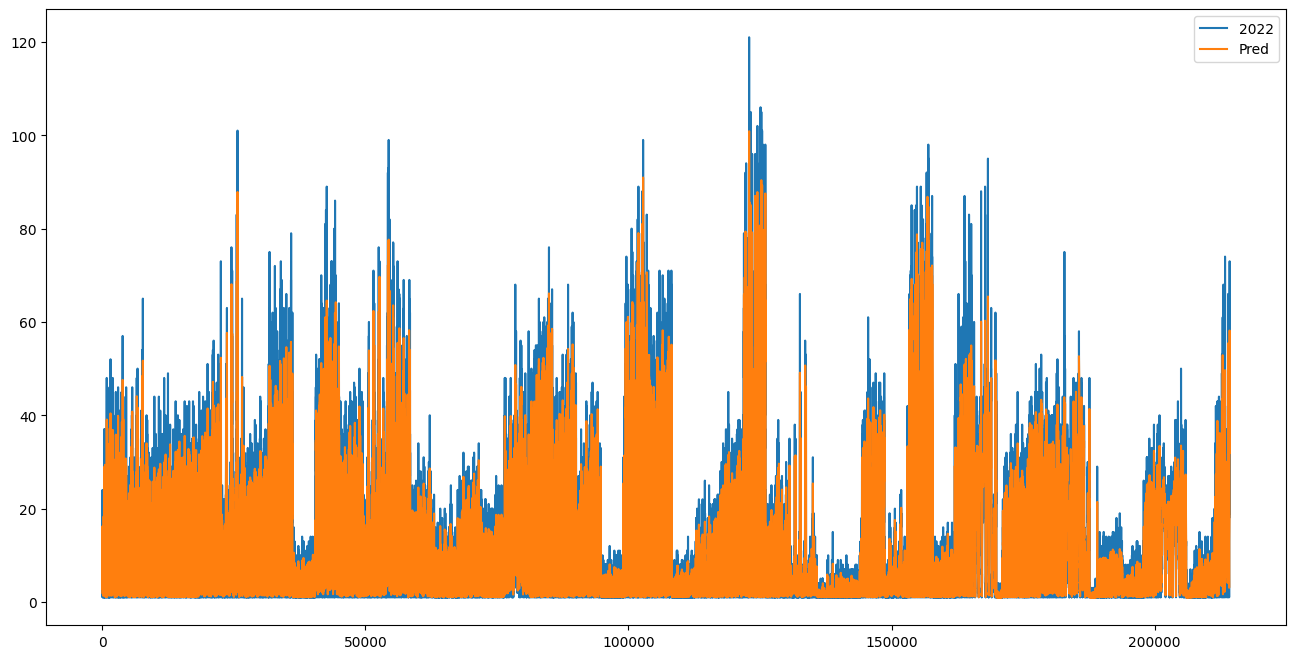

In [ ]:
print(exponential_moving_averages_prev(ratios_jan, 100))
print(exponential_moving_averages_prev(ratios_jan, 50))
print(exponential_moving_averages_prev(ratios_jan, 200))
print(exponential_moving_averages_prev(ratios_jan, 10))
print(exponential_moving_averages_prev(ratios_jan, 5))

(0.14586260557187697, 2.9293173926956046)


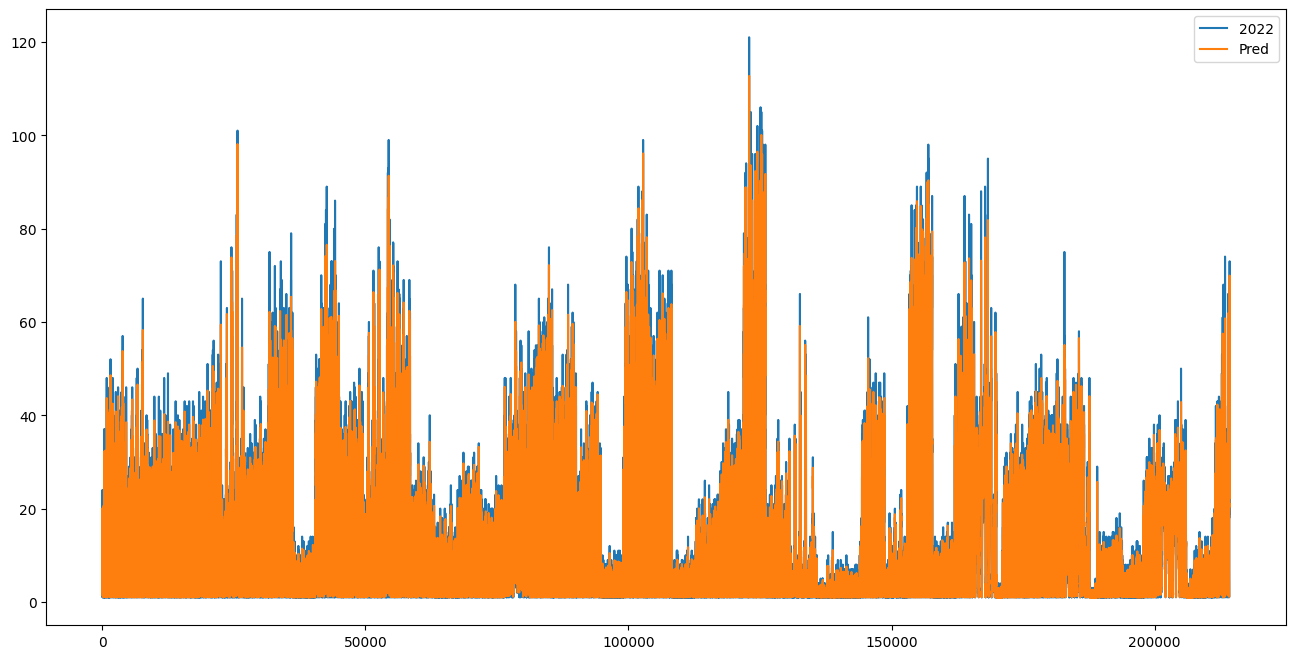

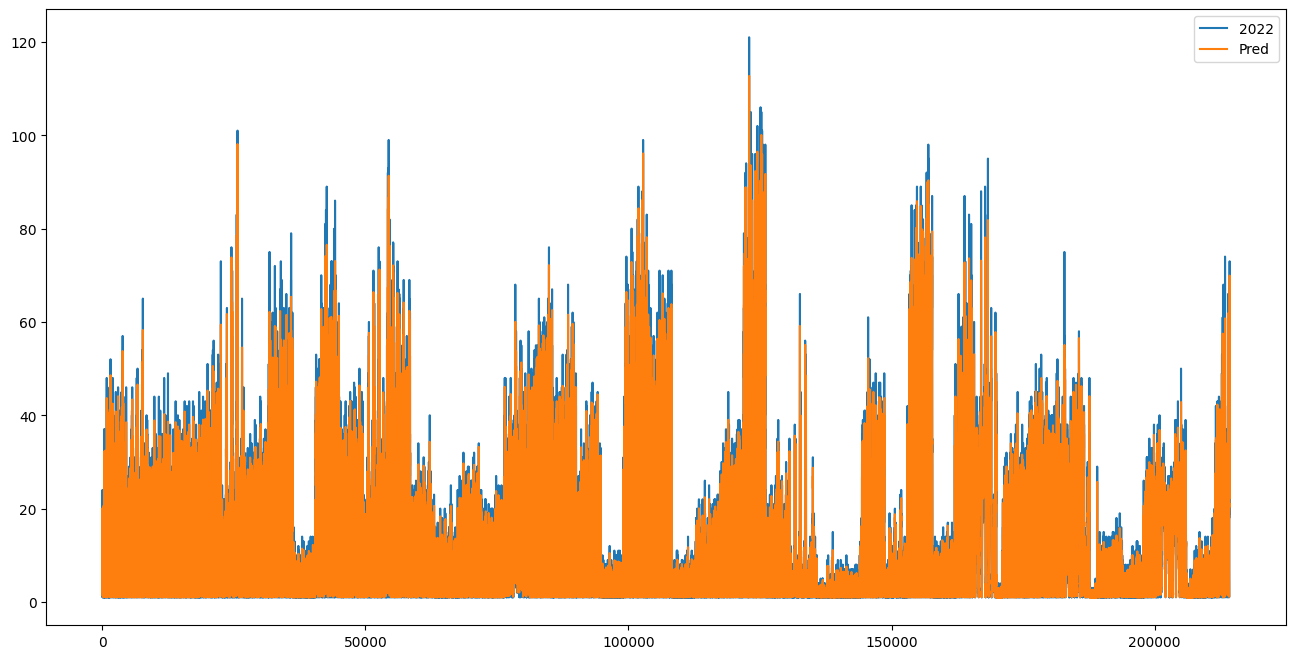

In [ ]:
print(exponential_moving_averages_prev(ratios_jan, 2))

Out of the four models we get the best result for exponential moving average when the window size is 2 and the model is based on previous values.
Therefore we set that as our bench marks

## REGRESSION

Preparing data to be split into train and test

In [ ]:
# we take number of pickups that are happened in last 5 10min intravels
number_of_time_stamps = 5

# output varaible
# it is list of lists
# it will contain number of pickups 12955 for each cluster
output = []

tsne_cluster =[]

# we will code each day
# sunday = 0, monday=1, tue = 2, wed=3, thur=4, fri=5,sat=6
# for every cluster we will be adding 12955 values, each value represent to which day of the week that pickup bin belongs to
# it is list of lists
tsne_weekday = []

#fi=number of pickups happened in i+1th 10min intravel(bin)
tsne_feature = []


tsne_feature = [0]*number_of_time_stamps
for i in range(0, 48):
    tsne_cluster.append([int(kmeans.cluster_centers_[0][0])]*12955)

    # jan 1st 2022 is Saturday, so we start our day from 2: "(int(k/144))%7+2"
    # our prediction start from 5th 10min intravel since we need to have number of pickups that are happened in last 5 pickup bins
    tsne_weekday.append([int(((int(k/144)) % 7+2) % 7)
                        for k in range(5, 4464+4032+4464)])
    tsne_feature = np.vstack((tsne_feature, [regions_cum[i][r:r+number_of_time_stamps]
                             for r in range(0, len(regions_cum[i])-number_of_time_stamps)]))
    output.append(regions_cum[i][5:])
tsne_feature = tsne_feature[1:]


In [ ]:
len(tsne_cluster[0])*len(tsne_cluster) == tsne_feature.shape[0] == len(tsne_weekday) * \
    len(tsne_weekday[0]) == 48*12955 == len(output)*len(output[0])


True

Getting the predictions of exponential moving averages to be used as a feature in cumulative form

From the baseline models we said the exponential weighted moving avarage gives us the best error
we will try to add the same exponential weighted moving avarage at t as a feature to our data
exponential weighted moving avarage => p'(t) = alpha*p'(t-1) + (1-alpha)*P(t-1)

In [ ]:
alpha = 0.3
predicted_values = [] # it is a temporary array that store exponential weighted moving avarage for each 10min intravel,
# for each cluster it will get reset

predict_list = []
tsne_flat_exp_avg = []
for r in range(0, 48):
    for i in range(0, 12960):
        if i == 0:
            predicted_value = regions_cum[r][0]
            predicted_values.append(0)
            continue
        predicted_values.append(predicted_value)
        predicted_value = int((alpha*predicted_value) +
                              (1-alpha)*(regions_cum[r][i]))
    predict_list.append(predicted_values[5:])
    predicted_values = []


Train, test split : 70% 30% split

We take 3 months of 2022 pickup data
and split it such that for every region we have 70% data in train and 30% in test,
ordered date-wise for every region

In [ ]:
print("size of train data :", int(12955*0.7))
print("size of test data :", int(12955*0.3))


size of train data : 9068
size of test data : 3886


Extracting first 9068 timestamp values i.e 70% of 12955 (total timestamps) for our training data

In [ ]:
train_features = [tsne_feature[i*12955:(12955*i+9068)] for i in range(0, 48)]
test_features = [tsne_feature[(12955*(i))+9068:12955*(i+1)]
                 for i in range(0, 48)]


In [ ]:
print("Number of data clusters", len(train_features), "Number of data points in train data", len(
    train_features[0]), "Each data point contains", len(train_features[0][0]), "features")
print("Number of data clusters", len(train_features), "Number of data points in test data",
      len(test_features[0]), "Each data point contains", len(test_features[0][0]), "features")


Number of data clusters 48 Number of data points in train data 9068 Each data point contains 5 features
Number of data clusters 48 Number of data points in test data 3887 Each data point contains 5 features


Extracting first 9068 timestamp values i.e 70% of 13099 (total timestamps) for our training data

In [ ]:
tsne_train_flat_cluster = [i[:9068] for i in tsne_cluster]
tsne_train_flat_weekday = [i[:9068] for i in tsne_weekday]
tsne_train_flat_output = [i[:9068] for i in output]
tsne_train_flat_exp_avg = [i[:9068] for i in predict_list]


Extracting the rest of the timestamp values i.e 30% of 12956 (total timestamps) for our test data

In [ ]:
tsne_test_flat_cluster = [i[9068:] for i in tsne_cluster]
tsne_test_flat_weekday = [i[9068:] for i in tsne_weekday]
tsne_test_flat_output = [i[9068:] for i in output]
tsne_test_flat_exp_avg = [i[9068:] for i in predict_list]


In [ ]:
train_new_features = []
for i in range(0, 48):
    train_new_features.extend(train_features[i])
test_new_features = []
for i in range(0, 48):
    test_new_features.extend(test_features[i])


In [ ]:
tsne_train_cluster = sum(tsne_train_flat_cluster, [])
tsne_train_weekday = sum(tsne_train_flat_weekday, [])
tsne_train_output = sum(tsne_train_flat_output, [])
tsne_train_exp_avg = sum(tsne_train_flat_exp_avg, [])


In [ ]:
tsne_test_cluster = sum(tsne_test_flat_cluster, [])
tsne_test_weekday = sum(tsne_test_flat_weekday, [])
tsne_test_output = sum(tsne_test_flat_output, [])
tsne_test_exp_avg = sum(tsne_test_flat_exp_avg, [])


Preparing the data frame for our train data

In [ ]:
columns = ['ft_5', 'ft_4', 'ft_3', 'ft_2', 'ft_1']
df_train = pd.DataFrame(data=train_new_features, columns=columns)
df_train['cluster'] = tsne_train_cluster
df_train['weekday'] = tsne_train_weekday
df_train['exp_avg'] = tsne_train_exp_avg

print(df_train.shape)


(435264, 8)


Preparing the data frame for our Test data

In [ ]:
df_test = pd.DataFrame(data=test_new_features, columns=columns)
df_test['cluster'] = tsne_test_cluster
df_test['weekday'] = tsne_test_weekday
df_test['exp_avg'] = tsne_test_exp_avg
print(df_test.shape)


(186576, 8)


In [ ]:
df_test.head()


,ft_5,ft_4,ft_3,ft_2,ft_1,cluster,weekday,exp_avg
0,27,27,39,38,38,131,2,37
1,27,39,38,38,28,131,2,30
2,39,38,38,28,35,131,2,33
3,38,38,28,35,42,131,2,39
4,38,28,35,42,39,131,2,39


## LINEAR REGRESSION

In [ ]:
from sklearn.linear_model import LinearRegression
lr_reg = LinearRegression().fit(df_train, tsne_train_output)

y_pred = lr_reg.predict(df_test)
lr_test_predictions = [round(value) for value in y_pred]
y_pred = lr_reg.predict(df_train)
lr_train_predictions = [round(value) for value in y_pred]


## USING RANDOM FOREST REGRESSOR

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
regr1 = RandomForestRegressor(
    max_features='sqrt', min_samples_leaf=4, min_samples_split=3, n_estimators=40, n_jobs=-1)
regr1.fit(df_train, tsne_train_output)


RandomForestRegressor(max_features='sqrt', min_samples_leaf=4,
                      min_samples_split=3, n_estimators=40, n_jobs=-1)

Predicting on test data using our trained random forest model

In [ ]:
y_pred = regr1.predict(df_test)
rndf_test_predictions = [round(value) for value in y_pred]
y_pred = regr1.predict(df_train)
rndf_train_predictions = [round(value) for value in y_pred]


Feature importances based on analysis using random forest

In [ ]:
print(df_train.columns)
print(regr1.feature_importances_)


Index(['ft_5', 'ft_4', 'ft_3', 'ft_2', 'ft_1', 'cluster', 'weekday',
       'exp_avg'],
      dtype='object')
[0.08207805 0.09502687 0.15876247 0.1794193  0.21122693 0.
 0.01001237 0.26347401]


## Using XgBoost Regressor

In [ ]:
df_train.dtypes

ft_5       int64
ft_4       int64
ft_3       int64
ft_2       int64
ft_1       int64
cluster    int64
weekday    int64
exp_avg    int64
dtype: object

In [ ]:
x_model = xgb.XGBRegressor(
    learning_rate=0.1,
    n_estimators=1000,
    max_depth=3,
    min_child_weight=3,
    gamma=0,
    subsample=0.8,
    reg_alpha=200, reg_lambda=200,
    colsample_bytree=0.8, nthread=4)
x_model.fit(df_train, tsne_train_output)


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=3, max_leaves=0, min_child_weight=3, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=4, nthread=4,
             num_parallel_tree=1, predictor='auto', ...)

Predicting with our trained Xg-Boost regressor

In [ ]:
y_pred = x_model.predict(df_test)
xgb_test_predictions = [round(value) for value in y_pred]
y_pred = x_model.predict(df_train)
xgb_train_predictions = [round(value) for value in y_pred]


In [ ]:
x_model.get_booster().get_score(importance_type='weight')

{'ft_5': 1168.0,
 'ft_4': 1112.0,
 'ft_3': 1108.0,
 'ft_2': 1050.0,
 'ft_1': 1097.0,
 'weekday': 435.0,
 'exp_avg': 898.0}

## Calculating the error metric values for various models

In [ ]:
train_mape = []
test_mape = []

train_mape.append((mean_absolute_error(tsne_train_output,
                  df_train['ft_1'].values))/(sum(tsne_train_output)/len(tsne_train_output)))
train_mape.append((mean_absolute_error(tsne_train_output,
                  df_train['exp_avg'].values))/(sum(tsne_train_output)/len(tsne_train_output)))
train_mape.append((mean_absolute_error(tsne_train_output, rndf_train_predictions)
                   )/(sum(tsne_train_output)/len(tsne_train_output)))
train_mape.append((mean_absolute_error(tsne_train_output, xgb_train_predictions)
                   )/(sum(tsne_train_output)/len(tsne_train_output)))
train_mape.append((mean_absolute_error(tsne_train_output, lr_train_predictions)
                   )/(sum(tsne_train_output)/len(tsne_train_output)))

test_mape.append((mean_absolute_error(tsne_test_output,
                 df_test['ft_1'].values))/(sum(tsne_test_output)/len(tsne_test_output)))
test_mape.append((mean_absolute_error(tsne_test_output,
                 df_test['exp_avg'].values))/(sum(tsne_test_output)/len(tsne_test_output)))
test_mape.append((mean_absolute_error(tsne_test_output, rndf_test_predictions)
                  )/(sum(tsne_test_output)/len(tsne_test_output)))
test_mape.append((mean_absolute_error(tsne_test_output, xgb_test_predictions)
                  )/(sum(tsne_test_output)/len(tsne_test_output)))
test_mape.append((mean_absolute_error(tsne_test_output, lr_test_predictions)
                  )/(sum(tsne_test_output)/len(tsne_test_output)))


In [ ]:
import math

In [ ]:
train_mse = []
test_mse = []

train_mse.append((math.sqrt(mean_squared_error(tsne_train_output,
                  df_train['ft_1'].values))))
train_mse.append(math.sqrt(mean_squared_error(tsne_train_output,
                  df_train['exp_avg'].values)))
train_mse.append(math.sqrt(mean_squared_error(tsne_train_output, rndf_train_predictions)
                   ))
train_mse.append(math.sqrt(mean_squared_error(tsne_train_output, xgb_train_predictions)
                   ))
train_mse.append(math.sqrt(mean_squared_error(tsne_train_output, lr_train_predictions)
                   ))

test_mse.append(math.sqrt(mean_squared_error(tsne_test_output,
                 df_test['ft_1'].values)))
test_mse.append(math.sqrt(mean_squared_error(tsne_test_output,
                 df_test['exp_avg'].values)))
test_mse.append(math.sqrt(mean_squared_error(tsne_test_output, rndf_test_predictions)
                  ))
test_mse.append(math.sqrt(mean_squared_error(tsne_test_output, xgb_test_predictions)
                  ))
test_mse.append(math.sqrt(mean_squared_error(tsne_test_output, lr_test_predictions)
                  ))

## Error Metric Matrix

In [ ]:
print("Error Metric Matrix (Mean Absolute Percentage Error) -  MAPE")
print("--------------------------------------------------------------------------------------------------------")
print("Baseline Model -                             Train: ",
      train_mape[0], "      Test: ", test_mape[0])
print("Exponential Averages Forecasting -           Train: ",
      train_mape[1], "      Test: ", test_mape[1])
print("Linear Regression -                         Train: ",
      train_mape[4], "      Test: ", test_mape[4])
print("Random Forest Regression -                   Train: ",
      train_mape[2], "     Test: ", test_mape[2])
print("XgBoost Regression -                         Train: ",
      train_mape[3], "      Test: ", test_mape[3])
print("--------------------------------------------------------------------------------------------------------")
print("Error Metric Matrix (Root Mean Square Error) -  RMSE")
print("--------------------------------------------------------------------------------------------------------")
print("Baseline Model -                             Train: ",
      train_mse[0], "      Test: ", test_mse[0])
print("Exponential Averages Forecasting -           Train: ",
      train_mse[1], "      Test: ", test_mse[1])
print("Linear Regression -                         Train: ",
      train_mse[4], "      Test: ", test_mse[4])
print("Random Forest Regression -                   Train: ",
      train_mse[2], "     Test: ", test_mse[2])
print("XgBoost Regression -                         Train: ",
      train_mse[3], "      Test: ", test_mse[3])
print("--------------------------------------------------------------------------------------------------------")



Error Metric Matrix (Mean Absolute Percentage Error) -  MAPE
--------------------------------------------------------------------------------------------------------
Baseline Model -                             Train:  0.3615896076277431       Test:  0.343820535261873
Exponential Averages Forecasting -           Train:  0.3310464397134092       Test:  0.3159634253074762
Linear Regression -                         Train:  0.3272546213857399       Test:  0.31071756631161385
Random Forest Regression -                   Train:  0.273355974879542      Test:  0.31393966449263383
XgBoost Regression -                         Train:  0.32687563806804415       Test:  0.3117313095950988
--------------------------------------------------------------------------------------------------------
Error Metric Matrix (Root Mean Square Error) -  RMSE
--------------------------------------------------------------------------------------------------------
Baseline Model -                             Train: 